<a href="https://colab.research.google.com/github/Blandalytics/xRP/blob/main/Pitch_Grade_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and Prep

In [ ]:
# Models are located on my Google Drive, for ease of access across multiple computers
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Install

In [ ]:
%cd /gdrive/MyDrive/Fantasy Analytics/Baseball/Pitch Grades

/gdrive/MyDrive/Fantasy Analytics/Baseball/Pitch Grades


In [ ]:
!pip install pybaseball -q

     |████████████████████████████████| 415 kB 13.7 MB/s 
     |████████████████████████████████| 291 kB 40.0 MB/s 
     |████████████████████████████████| 856 kB 37.0 MB/s 


In [ ]:
!pip install catboost -q

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


## Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import seaborn as sns
import catboost
import math
import datetime
import sys
import os
import pickle

from datetime import date, timedelta
from pybaseball import statcast, cache, plot_stadium
from catboost import CatBoostClassifier
from matplotlib import colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Arc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FuncFormatter)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import sin, cos, pi, linspace
from textwrap import wrap
from scipy import stats
from scipy.ndimage.filters import gaussian_filter1d

cache.enable()

## Define Style

In [ ]:
pl_white = '#FEFEFE'
pl_background = '#162B50'
pl_text = '#72a3f7'
pl_line_color = '#293a6b'

sns.set_theme(
    style={
        'axes.edgecolor': pl_line_color,
        'axes.facecolor': pl_background,
        'axes.labelcolor': pl_white,
        'xtick.color': pl_white,
        'ytick.color': pl_white,
        'figure.facecolor':pl_background,
        'grid.color': pl_background,
        'grid.linestyle': '-',
        'legend.facecolor':pl_background,
        'text.color': pl_white
     }
    )

In [ ]:
fm.fontManager.addfont('RobotoCondensed-Bold.ttf')
fm.fontManager.addfont('RobotoCondensed-Regular.ttf')
plt.rcParams['font.family'] = 'Roboto Condensed'

## Season Info

In [ ]:
# Define major season dates
now = datetime.datetime.now()
this_year = 2022
today = datetime.datetime(this_year, now.month, now.day)
season_start = datetime.datetime(this_year, 4, 7)
season_end = datetime.datetime(this_year, 10, 4)

# Calculate major lengths of time
days_played = (season_end if today > season_end else today) - season_start
season_length = season_end - season_start

# Define Thresholds (Season)
min_innings = round(days_played.days / season_length.days * 20)
min_pitches = min_innings * 14

## Batted Ball Thresholds

In [ ]:
launch_angle_labels = ['10deg','10-20deg','20-30deg','30-40deg','40-50deg','50+deg']
launch_angle_bins = [-90, 10, 20, 30, 40, 50, 180]

launch_velo_labels = ['<90mph','90-95mph','95-100mph','100-105mph','105+mph']
launch_velo_bins = [0, 90, 95, 100, 105, 150]

## Player Names

In [ ]:
# Load Batter Names from MLB ID
name_df = pd.read_csv('https://docs.google.com/spreadsheets/d/1JgczhD5VDQ1EiXqVG-blttZcVwbZd5_Ne_mefUGwJnk/export?format=csv&gid=0')
name_df = name_df[['MLBID','MLBNAME']].dropna().astype({'MLBID':'int'}).set_index('MLBID').to_dict()['MLBNAME']

## Load Data

In [ ]:
file_name = 'Statcast Pitch Data - {}.parquet.gzip'.format(this_year)

In [ ]:
raw_pitch_data = pd.read_parquet(file_name)
#raw_pitch_data = statcast(start_dt=(season_start).strftime('%Y-%m-%d'),end_dt=today.strftime('%Y-%m-%d'))

In [ ]:
# Add new data, if file is not current
if (raw_pitch_data['game_date'].max() + timedelta(days=1)) < today:
  new_data = statcast(start_dt=(raw_pitch_data['game_date'].max() + timedelta(days=1)).strftime('%Y-%m-%d'),end_dt=today.strftime('%Y-%m-%d'))
  raw_pitch_data = pd.concat([raw_pitch_data,new_data])

This is a large query, it may take a moment to complete


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


In [ ]:
raw_pitch_data.to_parquet(file_name, compression='gzip')

In [ ]:
# Drop unused columns to reduce file size/complexity
pitch_data = (
    raw_pitch_data
    .drop_duplicates(subset=['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
                             'release_pos_z', 'player_name', 'batter', 'plate_x', 'plate_z'])
    .drop(columns=[
                   'spin_rate_deprecated',
                   'break_angle_deprecated',
                   'break_length_deprecated',
                   'zone',
                   'des',
                   'game_type',
                   'hit_location',
                   'on_3b',
                   'on_2b',
                   'on_1b',
                   'outs_when_up',
                   'inning',
                   'tfs_deprecated',
                   'tfs_zulu_deprecated',
                   'fielder_2',
                   'umpire',
                   'sv_id',
                   'pitcher.1',
                   'fielder_2.1',
                   'fielder_3',
                   'fielder_4',
                   'fielder_5',
                   'fielder_6',
                   'fielder_7',
                   'fielder_8',
                   'fielder_9',
                   'babip_value',
                   'iso_value',
                   'fld_score',
                   'post_away_score',
                   'post_home_score',
                   'post_bat_score',
                   'post_fld_score',
                   'if_fielding_alignment',
                   'of_fielding_alignment',
                   'delta_home_win_exp',
                   'delta_run_exp'
    ])
    ).copy()

pitch_data = pitch_data.rename(columns={'estimated_ba_using_speedangle':'xBA','estimated_woba_using_speedangle':'xwOBA'})

pitch_data['xISO'] = pitch_data['xwOBA'].sub(pitch_data['xBA'].mul(0.9)) # Not really "ISO", but weighted by wOBA denoms. xSLG not in API

In [ ]:
# Team dict (Statcast Abbrev.: Stadium data team name)
teams = {'ARI':'diamondbacks', 
         'ATL':'braves', 
         'BAL':'orioles', 
         'BOS':'red_sox', 
         'CHC':'cubs', 
         'CIN':'reds', 
         'CLE':'indians', 
         'COL':'rockies', 
         'CWS':'white_sox',
         'DET':'tigers', 
         'HOU':'astros', 
         'KC':'royals', 
         'LAA':'angels', 
         'LAD':'dodgers', 
         'MIA':'marlins', 
         'MIL':'brewers', 
         'MIN':'twins', 
         'NYM':'mets',
         'NYY':'yankees', 
         'OAK':'athletics', 
         'PHI':'phillies', 
         'PIT':'pirates', 
         'SD':'padres', 
         'SEA':'mariners', 
         'SF':'giants', 
         'STL':'cardinals', 
         'TB':'rays', 
         'TEX':'rangers',
         'TOR':'blue_jays', 
         'WSH':'nationals'}

In [ ]:
# Determine batter's team, to add their home field overlay to the cards
pitch_data['bat_team'] = None
pitch_data.loc[pitch_data['inning_topbot']=='Bot','bat_team'] = pitch_data.loc[pitch_data['inning_topbot']=='Bot','home_team']
pitch_data.loc[pitch_data['inning_topbot']=='Top','bat_team'] = pitch_data.loc[pitch_data['inning_topbot']=='Top','away_team']

pitch_data['bat_team'] = pitch_data['bat_team'].map(teams)

In [ ]:
# Format/add player names
pitch_data['player_name'] = pitch_data['player_name'].str.split(', ').apply(lambda x: ' '.join(x[::-1]))
pitch_data['batter_name'] = pitch_data['batter'].map(name_df)

pitch_data['release_extension'] = 60.5 - pitch_data['release_pos_y']

# Standardize descriptions for model
pitch_data['cleaned_description'] = pitch_data['description'].replace({
    'swinging_strike':'swinging_strike',
    'foul':'foul_strike',
    'called_strike':'called_strike',
    'foul_tip':'swinging_strike',
    'swinging_strike_blocked':'swinging_strike',
    'foul_bunt':'foul_strike',
    'missed_bunt':'swinging_strike',
    'foul_pitchout':'foul_strike',
    'bunt_foul_tip':'swinging_strike',
    'swinging_pitchout':'swinging_strike',
    'blocked_ball':'ball',
    'hit_by_pitch':'ball',
    'pitchout':'ball'
})

# Show the PA outcome from each pitch
pitch_data['events'] = pitch_data['events'].replace('None',None)
pitch_data['pa_result'] = pitch_data['events'].fillna(method='ffill')

# Add pitch counts
pitch_data['appearance_pitch_count'] = pitch_data.groupby(['player_name','game_date'])['pitch_type'].transform(lambda x: x.count())
pitch_data['season_pitch_count'] = pitch_data.groupby('player_name')['pitch_type'].transform(lambda x: x.count())

### League Average Results

In [ ]:
# Determine wOBA values of various outcomes
woba_values = {
    'league':pitch_data['woba_value'].mean(),
    'strike':(0-pitch_data['woba_value'].mean())/3, # Strikes worth 1/3 of a strikeout
    'ball':(pitch_data.loc[pitch_data['events']=='walk','woba_value'].mean() - pitch_data['woba_value'].mean())/4, # Balls worth 1/4 of a walk
    'hit_by_pitch':pitch_data.loc[pitch_data['events']=='hit_by_pitch','woba_value'].mean() - pitch_data['woba_value'].mean()
}

In [ ]:
# Weigh strike values by finding the proportion of each strike type, compared to all strikes in strikeouts

# Find the proportion of each strike type in plate appearances that result in strikeouts
strikeout_ratios = pitch_data.loc[pitch_data['pa_result']=='strikeout'].groupby('cleaned_description', as_index=False)['pitch_number'].count().set_index('cleaned_description').drop('ball')
strikeout_strikes = strikeout_ratios.reset_index(drop=True).sum()
strikeout_ratios = strikeout_ratios.div(strikeout_strikes)

# Find the proportion of each strike type in the total sample
population_ratios = pitch_data.groupby('cleaned_description', as_index=False)['pitch_number'].count().set_index('cleaned_description').drop(['ball','hit_into_play'])
population_strikes = population_ratios.reset_index(drop=True).sum()
population_ratios = population_ratios.div(population_strikes)

# Find ratio of the strikeout proportion to the population proportion
strike_type_weight = strikeout_ratios.div(population_ratios)
strike_type_weight = strike_type_weight.rename(columns={'pitch_number':'strike_weight'})
strike_type_weight['strike_weight'] = strike_type_weight['strike_weight'].mul(3).div(strike_type_weight['strike_weight'].sum()) # Strike weights should add to # of strike types (3)

strike_type_woba = strike_type_weight.mul(woba_values['strike']).to_dict()['strike_weight']

In [ ]:
# Add in batted ball outcomes, in the model buckets
pitch_data.loc[pitch_data['cleaned_description']=='hit_into_play','bb_type'] = pd.cut(pitch_data.loc[pitch_data['cleaned_description']=='hit_into_play','launch_angle'].fillna(pitch_data['launch_angle'].median()), bins=launch_angle_bins, labels=launch_angle_labels)
pitch_data.loc[pitch_data['cleaned_description']=='hit_into_play','bb_velocity'] = pd.cut(pitch_data.loc[pitch_data['cleaned_description']=='hit_into_play','launch_speed'].fillna(pitch_data['launch_speed'].median()), bins=launch_velo_bins, labels=launch_velo_labels)
pitch_data.loc[pitch_data['cleaned_description']=='hit_into_play','bb_bucket'] = pitch_data.loc[pitch_data['cleaned_description']=='hit_into_play','bb_type'].astype('str')+': '+pitch_data.loc[pitch_data['cleaned_description']=='hit_into_play','bb_velocity'].astype('str')

pitch_data.loc[pitch_data['bb_type']=='50+deg','bb_bucket'] = '50+deg' # Launch speed not relevent for Popups

bb_wOBA_values = pitch_data.loc[pitch_data['cleaned_description']=='hit_into_play'].groupby('bb_bucket')['woba_value'].mean().sub(woba_values['league']).to_dict()

In [ ]:
# Combine general, batted ball, and strike wOBA values
woba_values = {
    **woba_values,
    **bb_wOBA_values,
    **strike_type_woba
}

# Exclude non-modeled wOBA values
woba_values = {key:val for key, val in woba_values.items() if key not in  ['league','strike','nan: <90mph']}

# Models

## Model Prep

In [ ]:
# Classification from https://www.drivelinebaseball.com/2021/12/what-is-stuff-quantifying-pitches-with-pitch-models/
# Listing Cutters as Fastballs, because otherwise some pitchers have no fastball to compare to

fastballs = ['4-Seam Fastball', 'Sinker', 'Cutter', 'Fastball']
breaking = ['Slider', 'Curveball', 'Knuckle Curve', '2-Seam Fastball']
offspeed = ['Split-Finger', 'Changeup', 'Eephus']

pitch_classes = {'Fastballs':fastballs,
                 'Breaking':breaking,
                 'Offspeed':offspeed}

In [ ]:
pitch_data = (
    pitch_data
    # Drop columns with missing data (there are very few records. Thanks PyBaseball!)
    .dropna(subset=['player_name', 'game_date', 'game_year', 'pitch_name', 
              'release_speed', 'pfx_x', 'pfx_z', 'p_throws', 'stand', 'balls', 
              'strikes', 'plate_x', 'plate_z', 'release_spin_rate', 
              'release_extension','spin_axis'])
    .astype({
        'release_speed':'float',
        'pfx_x':'float',
        'pfx_z':'float',
        'plate_x':'float',
        'plate_z':'float',
        'sz_top':'float', 
        'sz_bot':'float',
        'release_spin_rate':'int',
        'spin_axis':'int',
        'release_extension':'float',
        'p_throws':'category',
        'stand':'category',
        'balls':'category',
        'strikes':'category'
    })
    .rename(columns={
        'release_speed':'velocity',
        'pfx_x':'h_move',
        'pfx_z':'v_move',
        'p_throws':'p_hand',
        'stand':'b_hand',
        'plate_x':'h_loc',
        'plate_z':'v_loc',
        'release_spin_rate':'spin_rate'
    })
)

# Liner 2-d movement (work on measuring by ball path, instead?)
pitch_data['total_move'] = (pitch_data['h_move']**2+pitch_data['v_move']**2)**0.5

# Determine which fastball a pitcher throws most often in a start
fastball_df = (pitch_data
    .loc[pitch_data['pitch_name'].isin(fastballs)]
    .groupby(['player_name','game_date'], as_index=False)
    ['pitch_name']
    .agg(pd.Series.mode)
    .rename(columns={'pitch_name':'fastball_type'})
)

pitch_data = pitch_data.merge(fastball_df,on=['player_name','game_date'])
pitch_data['fastball_type'] = pitch_data['fastball_type'].apply(lambda x: x if len(x[0])==1 else x[0])

# Find differences in value from most common fastball for all pitches
for stat in ['h_move','v_move','total_move','velocity','spin_axis']:
  temp_df = pitch_data.loc[pitch_data['pitch_name']==pitch_data['fastball_type']].groupby(['player_name','game_date','pitch_name'], as_index=False)[stat].mean().rename(columns={stat:'fb_'+stat})
  pitch_data = pitch_data.merge(temp_df,left_on=['player_name','game_date','fastball_type'], right_on=['player_name','game_date','pitch_name']).drop(columns=['pitch_name_y']).rename(columns={'pitch_name_x':'pitch_name'})
  pitch_data[stat+'_diff'] = pitch_data[stat].sub(pitch_data['fb_'+stat])

In [ ]:
# Define feature sets for models (Pitching model uses all)
stuff_feats = ['velocity', 'h_move', 'v_move', 'spin_rate', 
               'release_extension', 'total_move', 'fb_h_move', 'h_move_diff', 
               'fb_v_move', 'v_move_diff', 'fb_total_move', 'total_move_diff',
               'fb_velocity', 'velocity_diff', 'spin_axis',
               'spin_axis_diff']

command_feats = ['h_loc', 'v_loc']

category_feats = ['pitch_name','p_hand','b_hand']

In [ ]:
# Model List (all are classifiers)
model_list = { # model: model type
    'swing':'Logloss',
    'no_swing_result':'MultiClass',
    'swing_result':'Logloss',
    'contact_result':'Logloss',
    'launch_angle_result':'MultiClass',
    '10deg_result':'MultiClass',
    '10-20deg_result':'MultiClass',
    '20-30deg_result':'MultiClass',
    '30-40deg_result':'MultiClass',
    '40-50deg_result':'MultiClass',
    'home_run':'Logloss'
}

model_groups = { # model: [feature inputs, data]
    'pitching':[stuff_feats+command_feats+category_feats,pitch_data],
    'stuff':[stuff_feats+category_feats,pitch_data.loc[pitch_data['description'].isin(['foul_strike','swinging_strike','hit_into_play'])].copy()],
    'command':[command_feats+category_feats,pitch_data]
}

## Apply Models

In [ ]:
## Note: "Command" is shown on the cards as "Location"
## need to update "Command" > "Location" for the object names in the code and the model file names

In [ ]:
# Load and Apply Models
for group in model_groups.keys():
    model_feats = model_groups[group][0]
    _model_list = {key:val for key, val in model_list.items() if key not in ['swing','no_swing_result']} if group=='stuff' else model_list
    for model in _model_list.keys():
        # Load
        with open('Model Files/'+model+'_model_'+group[0]+'.pkl', 'rb') as f:
            temp_model = pickle.load(f)
        # Apply
        pitch_data[[str(x)+'_raw_'+group[0] for x in temp_model.classes_]] = temp_model.predict_proba(pitch_data.loc[:,model_feats])

# Pitching/Location model
# Combine Models to predict specific outcomes
for model in ['pitching','command']:
    for stat in ['ball','called_strike','hit_by_pitch']:
        pitch_data[stat+'_pred_'+model[0]] = pitch_data['no_swing_raw_'+model[0]].mul(pitch_data[stat+'_raw_'+model[0]])

# Combine values to get final probability        
for model in ['pitching','command']:
    pitch_data['swinging_strike_pred_'+model[0]] = pitch_data['swing_raw_'+model[0]].mul(pitch_data['swinging_strike_raw_'+model[0]])
    pitch_data['foul_strike_pred_'+model[0]] = pitch_data['swing_raw_'+model[0]].mul(pitch_data['contact_raw_'+model[0]]).mul(pitch_data['foul_strike_raw_'+model[0]])
    pitch_data['50+deg_pred_'+model[0]] = pitch_data['swing_raw_'+model[0]].mul(pitch_data['contact_raw_'+model[0]]).mul(pitch_data['hit_into_play_raw_'+model[0]]).mul(pitch_data['50+deg_raw_'+model[0]])
    for bb_type in ['10deg','10-20deg','20-30deg','30-40deg','40-50deg']:
        for velo in launch_velo_labels:
            pitch_data[bb_type+': '+velo+'_pred_'+model[0]] = pitch_data['swing_raw_'+model[0]].mul(pitch_data['contact_raw_'+model[0]]).mul(pitch_data['hit_into_play_raw_'+model[0]]).mul(pitch_data[bb_type+'_raw_'+model[0]]).mul(pitch_data[bb_type+': '+velo+'_raw_'+model[0]])

# Stuff model            
pitch_data['swinging_strike_pred_s'] = pitch_data['swinging_strike_raw_s']
pitch_data['foul_strike_pred_s'] = pitch_data['contact_raw_s'].mul(pitch_data['foul_strike_raw_s'])
pitch_data['50+deg_pred_s'] = pitch_data['contact_raw_s'].mul(pitch_data['hit_into_play_raw_s']).mul(pitch_data['50+deg_raw_s'])
for bb_type in ['10deg','10-20deg','20-30deg','30-40deg','40-50deg']:
    for velo in launch_velo_labels:
        pitch_data[bb_type+': '+velo+'_pred_s'] = pitch_data['contact_raw_s'].mul(pitch_data['hit_into_play_raw_s']).mul(pitch_data[bb_type+'_raw_s']).mul(pitch_data[bb_type+': '+velo+'_raw_s'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

In [ ]:
# Highest Swinging strike probability for fastballs
pitch_data.loc[(pitch_data['pitch_type']>='FF')].groupby('player_name')[['pitch_name','swinging_strike_pred_p']].agg({
    'pitch_name':'count',
    'swinging_strike_pred_p':'mean'
}).sort_values('swinging_strike_pred_p', ascending=False).head(20)

,pitch_name,swinging_strike_pred_p
player_name,,
Emmanuel Clase,119,0.240845
Ethan Roberts,37,0.221643
Tanner Scott,559,0.210055
Camilo Doval,284,0.202339
Liam Hendriks,388,0.188136
Collin McHugh,223,0.187277
Justin Wilson,36,0.186479
Kevin Gausman,1333,0.184045
Carlos Rodón,1245,0.183174


In [ ]:
# Apply wOBA Values to the probabilities
for group in model_groups.keys():
  stat_preds = [x for x in woba_values.keys() if x not in ['ball','hit_by_pitch','called_strike']] if group=='stuff' else woba_values.keys()
  for stat in stat_preds:
    pitch_data[stat+'_pred_wOBA_'+group[0]] = pitch_data[stat+'_pred_'+group[0]] * woba_values[stat]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


In [ ]:
# Consolidate predictions
pitch_data['pitch_wOBA'] = pitch_data[[stat[:-7]+'_pred_wOBA_p' for stat in pitch_data.columns if '_pred_p' in stat]].sum(axis=1)
pitch_data['stuff_wOBA'] = pitch_data[[stat[:-7]+'_pred_wOBA_s' for stat in pitch_data.columns if '_pred_s' in stat]].sum(axis=1)
pitch_data['command_wOBA'] = pitch_data[[stat[:-7]+'_pred_wOBA_c' for stat in pitch_data.columns if '_pred_c' in stat]].sum(axis=1)

avg_lg_pitch_wOBA = pitch_data['pitch_wOBA'].mean()

# Standardize to 0 ()
pitch_data['pitch_wOBA'] = pitch_data['pitch_wOBA'].sub(avg_lg_pitch_wOBA)
pitch_data['adj_pitch_wOBA'] = pitch_data['pitch_wOBA'].max() - pitch_data['pitch_wOBA']

# From https://www.fangraphs.com/guts.aspx?type=cn
pitch_data['xRuns_prevented'] = -pitch_data['pitch_wOBA'].div(1.289)

In [ ]:
avg_lg_pitch_wOBA

-0.007616042435159285

In [ ]:
# Home run predictions for each model
pitch_data = pitch_data.rename(columns={
    '0_raw_p':'no_home_run_pred_p', 
    '1_raw_p':'home_run_pred_p', 
    '0_raw_s':'no_home_run_pred_s', 
    '1_raw_s':'home_run_pred_s', 
    '0_raw_c':'no_home_run_pred_c', 
    '1_raw_c':'home_run_pred_c'
})

In [ ]:
pitch_data.pivot(columns='pitch_name',values='xRuns_prevented').sub(pitch_data['xRuns_prevented'].mean()).describe()

pitch_name,4-Seam Fastball,Changeup,Curveball,Cutter,Eephus,Fastball,Knuckle Curve,Knuckleball,Sinker,Slider,Split-Finger
count,106322.000000,37668.000000,26621.000000,21899.000000,156.000000,489.000000,5774.000000,14.000000,49087.000000,67905.000000,4806.000000
mean,-0.000387,-0.001800,-0.001176,0.001751,-0.032486,-0.029910,-0.002236,-0.036146,-0.004340,0.004943,0.002593
std,0.044268,0.041222,0.042390,0.040224,0.057533,0.044006,0.039629,0.074328,0.040540,0.041051,0.042876
min,-0.287732,-0.274414,-0.267156,-0.256375,-0.251304,-0.265978,-0.224029,-0.227311,-0.281707,-0.260816,-0.254935
25%,-0.037221,-0.034692,-0.034966,-0.026109,-0.074612,-0.069761,-0.032445,-0.078157,-0.031649,-0.023679,-0.029752
50%,0.014064,0.011098,0.012941,0.014107,-0.047743,-0.026097,0.010895,-0.023334,0.008169,0.017587,0.016993
75%,0.035206,0.031708,0.033891,0.033926,0.026565,0.007370,0.029645,0.026240,0.027103,0.037441,0.036995
max,0.076287,0.072348,0.075925,0.068843,0.063025,0.057489,0.060472,0.041604,0.064522,0.084403,0.067392


In [ ]:
# each batter's strike-zone is different (and is called differently)
# vertically adjust each pitch to fit a 'generic' 24" strike-zone centered at 2.5'
# generic dimensions from http://tangotiger.net/strikezone/zone%20chart.png
pitch_data['adj_v_cent'] = pitch_data['sz_bot'] + ((pitch_data['sz_top'] - pitch_data['sz_bot']) / 2) # dynamic zone center
pitch_data['adj_v_scale'] = (pitch_data['sz_top'] - pitch_data['sz_bot']) / 2 # scale to 2' vertical span
pitch_data['adj_v_loc'] = (pitch_data['v_loc'] - pitch_data['adj_v_cent']) * pitch_data['adj_v_scale'] + 2.5 
pitch_data['adj_v_loc'] = pitch_data['adj_v_loc'].astype('float')
pitch_data[['v_loc','adj_v_loc']].describe()

,v_loc,adj_v_loc
count,320741.000000,320741.000000
mean,2.297157,2.316346
std,0.970383,0.877027
min,-4.230000,-3.586125
25%,1.660000,1.744700
50%,2.300000,2.325925
75%,2.940000,2.896000
max,7.750000,7.539100


In [ ]:
# Average velocity for each pitch type, per pitcher
pitch_data = pitch_data.merge(pitch_data.groupby(['player_name','pitch_name'],as_index=False)['velocity'].mean().rename(columns={'velocity':'avg_velo'}),how='left', on=['player_name','pitch_name'])

## Predictive xRP?

In [ ]:
per_game_xRP = pitch_data.groupby(['player_name','game_date'], as_index=False)[['xRuns_prevented','pitch_name']].agg({
    'xRuns_prevented':'mean',
    'pitch_name':'count'
})
per_game_xRP['max_date'] = per_game_xRP['game_date'].groupby(per_game_xRP['player_name']).transform('max')
per_game_xRP['game_weight'] = 0.99 ** (per_game_xRP['max_date'] - per_game_xRP['game_date']).dt.days # Need to figure out the right value to use as base for exponential decay (0.99 seemed like a good start)
per_game_xRP['weighted_xRP'] = per_game_xRP['xRuns_prevented'].mul(per_game_xRP['game_weight'])
weighted_xRP_df = per_game_xRP.groupby('player_name', as_index=False)[['weighted_xRP','game_weight','pitch_name']].sum()
weighted_xRP_df['weighted_xRP'] = weighted_xRP_df['weighted_xRP'].div(weighted_xRP_df['game_weight'])
weighted_xRP_df.loc[weighted_xRP_df['pitch_name']>=400,['player_name','weighted_xRP']].sort_values('weighted_xRP', ascending=False).head(15)

,player_name,weighted_xRP
629,Tanner Scott,0.012259
0,A.J. Minter,0.011291
398,Keegan Akin,0.010986
93,Brusdar Graterol,0.010875
395,Justin Verlander,0.010649
113,Carlos Rodón,0.010091
104,Caleb Thielbar,0.009965
608,Shane McClanahan,0.009951
616,Spencer Strider,0.009721
671,Tyler Rogers,0.009256


In [145]:
#pitch_data.loc[pitch_data['season_pitch_count']>=600].groupby('player_name')['xRuns_prevented'].mean().sort_values(ascending=False).head(10)

player_name
Keegan Akin         0.011198
Justin Verlander    0.010470
Carlos Rodón        0.010071
Shane McClanahan    0.009823
Kevin Gausman       0.008972
Julio Urías         0.008144
Spencer Strider     0.007962
George Kirby        0.007926
Drew Rasmussen      0.007517
Zack Wheeler        0.007360
Name: xRuns_prevented, dtype: float64

## Best Results

In [ ]:
best_seasons = pitch_data.groupby('player_name')[['pitch_name','pitch_wOBA','stuff_wOBA','command_wOBA']].agg({
    'pitch_name':'count',
    'pitch_wOBA':'mean',
    'stuff_wOBA':'mean',
    'command_wOBA':'mean'
}).sort_values('pitch_wOBA')
best_seasons.loc[best_seasons['pitch_name']>=300].head(50)

,pitch_name,pitch_wOBA,stuff_wOBA,command_wOBA
player_name,,,,
Emmanuel Clase,383,-0.018922,-0.075301,-0.016960
Keegan Akin,654,-0.014435,-0.058292,-0.018221
Tanner Scott,559,-0.013832,-0.080930,-0.008856
Justin Verlander,1313,-0.013496,-0.063109,-0.017206
Erik Swanson,321,-0.013085,-0.062949,-0.014771
Carlos Rodón,1332,-0.012982,-0.069788,-0.009398
Shane McClanahan,1345,-0.012662,-0.076449,-0.011132
Brusdar Graterol,465,-0.011727,-0.059956,-0.015048
Kevin Gausman,1370,-0.011565,-0.064609,-0.014117


In [ ]:
# Most extreme horizontal deliveries
pitch_data.groupby('player_name')['release_pos_x'].median().sort_values()

player_name
Jose Cuas         -4.48
Scott Effross     -4.32
Trevor Kelley     -4.21
Tyler Rogers      -4.19
Jake Reed         -4.13
                   ... 
Tim Hill            3.8
Danny Young        3.81
Joely Rodríguez    3.86
Hoby Milner         4.1
Aaron Loup         4.22
Name: release_pos_x, Length: 713, dtype: Float64

# Visualizations

## Style Prep

In [ ]:
pitch_data.groupby('pitch_name')['velocity'].count().sort_values(ascending=False)

pitch_name
4-Seam Fastball    106322
Slider              67905
Sinker              49087
Changeup            37668
Curveball           26621
Cutter              21899
Knuckle Curve        5774
Split-Finger         4806
Fastball              489
Eephus                156
Knuckleball            14
Name: velocity, dtype: int64

In [ ]:
pitches = pitch_data.sort_values('velocity', ascending=False)['pitch_name'].unique()

# Explicitly map markers and colors
marker_list = {
    '4-Seam Fastball':'o', 
    'Sinker':'X', 
    'Cutter':'v', 
    'Split-Finger':'>', 
    'Slider':'P',
    'Changeup':'s', 
    '2-Seam Fastball':'H', 
    'Knuckle Curve':'^', 
    'Curveball':'D',
    'Fastball':'d', 
    'Eephus':'<', 
    'Knuckleball':'*'
}

marker_colors = {
    '4-Seam Fastball':'#1f77b4', 
    'Sinker':'#ff7f0e', 
    'Cutter':'#2ca02c', 
    'Split-Finger':'#d62728', 
    'Slider':'#9467bd',
    'Changeup':'#8c564b', 
    '2-Seam Fastball':'#333333', 
    'Knuckle Curve':'#7f7f7f', 
    'Curveball':'#e377c2',
    'Fastball':'#aec7e8', 
    'Eephus':'#17becf', 
    'Knuckleball':'#bcbd22'
}

In [ ]:
# General hue normalization for xRP (all pitches)
norm = colors.TwoSlopeNorm(vmin=pitch_data['xRuns_prevented'].quantile(0.01), 
                           vcenter=0,
                           vmax=pitch_data['xRuns_prevented'].quantile(0.99))

# Per-Appearance hue normalization for
max_app_xRP = pitch_data.groupby(['game_date','player_name'])['xRuns_prevented'].sum().max()
min_app_xRP = pitch_data.groupby(['game_date','player_name'])['xRuns_prevented'].sum().min()
game_norm = colors.TwoSlopeNorm(vmin=pitch_data.groupby(['game_date','player_name'])['xRuns_prevented'].sum().quantile(0.001), 
                                vcenter=0,
                                vmax=pitch_data.groupby(['game_date','player_name'])['xRuns_prevented'].sum().quantile(0.999))

# Percentage of pitches that are in 2-strike and 3-ball counts
strikeout_threshold = pitch_data.loc[pitch_data['strikes']==2].shape[0] / pitch_data.shape[0]
walk_threshold = pitch_data.loc[pitch_data['balls']==3].shape[0] / pitch_data.shape[0]

# General constants for formatting charts and sizing
y_lim = 5.5
y_bot = -1
sz_bot = 1.5
sz_top = 3.5

In [ ]:
# For Styling bullet charts
bullet_limits = [20,40,60,80,101]
palette = sns.color_palette('vlag', len(bullet_limits))
bullet_text_palette = ['#2d5286', '#7e8ca6', '#666666', '#b37670', '#86312d']

In [ ]:
# Show Start/Appearance date if there are few, otherwise show months w/ day ticks
def x_ticks_format(ax,game_dates,scale_val):
  if len(game_dates.unique())<10:
    ax.tick_params(left=False, bottom=False, labelsize=round(10*scale_val))
    ax.set_xticks([x for x in game_dates.unique()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%-d'))
  else:
    ax.tick_params(left=False, labelsize=round(10*scale_val))
#    ax.set_xlim(game_dates.min().replace(day=1))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator(minticks=3, maxticks=8),show_offset=False))
    ax.xaxis.set_minor_locator(mdates.DayLocator())

## Functions to prep data

In [ ]:
# Chart with the kdeplots for each pitch type's velocities
def velo_chart(df,player_name):
  pitch_speed_df = df.loc[df['player_name']==player_name,['player_name','pitch_name','velocity']].copy().sort_values('velocity',ascending=False)
  speeds = sns.FacetGrid(pitch_speed_df, row='pitch_name', hue='pitch_name', aspect=15, height=.5)

  speeds.map(sns.kdeplot, 'velocity',
             bw_adjust=.5, clip_on=False,
             fill=True, alpha=1, linewidth=1.5)
  speeds.map(sns.kdeplot, 'velocity', clip_on=False, color='w', lw=2, bw_adjust=.5)
  speeds.refline(y=0, linewidth=2, linestyle='-', color=None, clip_on=False)

  # Remove axes details that don't play well with overlap
  speeds.set_titles('')
  speeds.set(yticks=[], ylabel='')
  speeds.despine(bottom=True, left=True)

In [ ]:
# Format the data to play well with the bullet chart (since we re-adjust percentiles if a pitcher has a low season pitch count)
def bullet_data(df,time_frame='year',game_date='',pitch_count=50):
  bullet_df = (
      df
      .copy()
      [['player_name','game_date','pitch_wOBA','stuff_wOBA','command_wOBA',
        'swinging_strike_pred_p','called_strike_pred_p','swing_raw_p',
        '10deg: <90mph_pred_p',
        '10deg: 90-95mph_pred_p',
        '10deg: 95-100mph_pred_p',
        '10deg: 100-105mph_pred_p',
        '10deg: 105+mph_pred_p',
        '10-20deg: 95-100mph_pred_p',
        '10-20deg: 100-105mph_pred_p',
        '10-20deg: 105+mph_pred_p',
        '20-30deg: 95-100mph_pred_p',
        '20-30deg: 100-105mph_pred_p',
        '20-30deg: 105+mph_pred_p',
        '30-40deg: 95-100mph_pred_p',
        '30-40deg: 100-105mph_pred_p',
        '30-40deg: 105+mph_pred_p',
        '40-50deg: 95-100mph_pred_p',
        '40-50deg: 100-105mph_pred_p',
        '40-50deg: 105+mph_pred_p',
        'home_run_pred_p']]
      )
  bullet_df['whiff_pred'] = bullet_df['swinging_strike_pred_p'].div(bullet_df['swing_raw_p'])
  bullet_df['csw_pred'] = bullet_df['swinging_strike_pred_p'].add(bullet_df['called_strike_pred_p'])
  bullet_df['hard_air_pred'] = bullet_df[['10-20deg: 95-100mph_pred_p',
                                          '10-20deg: 100-105mph_pred_p',
                                          '10-20deg: 105+mph_pred_p',
                                          '20-30deg: 95-100mph_pred_p',
                                          '20-30deg: 100-105mph_pred_p',
                                          '20-30deg: 105+mph_pred_p',
                                          '30-40deg: 95-100mph_pred_p',
                                          '30-40deg: 100-105mph_pred_p',
                                          '30-40deg: 105+mph_pred_p',
                                          '40-50deg: 95-100mph_pred_p',
                                          '40-50deg: 100-105mph_pred_p',
                                          '40-50deg: 105+mph_pred_p']].sum(axis=1)
  bullet_df['gb_pred'] = bullet_df[['10deg: <90mph_pred_p',
                                    '10deg: 90-95mph_pred_p',
                                    '10deg: 95-100mph_pred_p',
                                    '10deg: 100-105mph_pred_p',
                                    '10deg: 105+mph_pred_p']].sum(axis=1)
  bullet_df = bullet_df.groupby(['player_name'] if time_frame=='year' else ['player_name','game_date'],as_index=False)[['pitch_wOBA','stuff_wOBA','command_wOBA','csw_pred','hard_air_pred','gb_pred','home_run_pred_p']].mean()

  bullet_df = bullet_df.merge(df.groupby(['player_name'] if time_frame=='year' else ['player_name','game_date'],as_index=False)['pitch_name'].agg({
      'pitch_name':'count'
  }).rename(columns={'pitch_name':'pitch_count'}),how='left', on=['player_name'] if time_frame=='year' else ['player_name','game_date'])

  bullet_df = bullet_df.loc[bullet_df['pitch_count']>=pitch_count]
  bullet_df['xRP_percentile'] = round(1-bullet_df['pitch_wOBA'].rank(pct=True),2)
  bullet_df['stuff_percentile'] = round(1-bullet_df['stuff_wOBA'].rank(pct=True),2)
  bullet_df['command_percentile'] = round(1-bullet_df['command_wOBA'].rank(pct=True),2)
  bullet_df['csw_percentile'] = bullet_df['csw_pred'].rank(pct=True).round(2)
  bullet_df['home_run_percentile'] = round(1-bullet_df['home_run_pred_p'].rank(pct=True),2)
  bullet_df['hard_air_percentile'] = round(1-bullet_df['hard_air_pred'].rank(pct=True),2)
  bullet_df['gb_percentile'] = bullet_df['gb_pred'].rank(pct=True).round(2)

  return bullet_df if time_frame=='year' else bullet_df.loc[bullet_df['game_date']==game_date]

In [ ]:
# Format the data to play well with the bullet chart, for each pitch type (since we re-adjust percentiles if a pitcher has a low season pitch count)
def pitch_bullet_data(df,pitch_count=50, pitch_type='4-Seam Fastball'):
  bullet_df = (
      df
      .loc[df['pitch_name']==pitch_type]
      .copy()
      [['player_name','pitch_name','game_date','pitch_wOBA','stuff_wOBA',
        'command_wOBA','swinging_strike_pred_p','called_strike_pred_p',
        'swing_raw_p',
        '10deg: <90mph_pred_p',
        '10deg: 90-95mph_pred_p',
        '10deg: 95-100mph_pred_p',
        '10deg: 100-105mph_pred_p',
        '10deg: 105+mph_pred_p',
        '10-20deg: 95-100mph_pred_p',
        '10-20deg: 100-105mph_pred_p',
        '10-20deg: 105+mph_pred_p',
        '20-30deg: 95-100mph_pred_p',
        '20-30deg: 100-105mph_pred_p',
        '20-30deg: 105+mph_pred_p',
        '30-40deg: 95-100mph_pred_p',
        '30-40deg: 100-105mph_pred_p',
        '30-40deg: 105+mph_pred_p',
        '40-50deg: 95-100mph_pred_p',
        '40-50deg: 100-105mph_pred_p',
        '40-50deg: 105+mph_pred_p',
        'home_run_pred_p']]
      )
  bullet_df['whiff_pred'] = bullet_df['swinging_strike_pred_p'].div(bullet_df['swing_raw_p'])
  bullet_df['csw_pred'] = bullet_df['swinging_strike_pred_p'].add(bullet_df['called_strike_pred_p'])
  bullet_df['hard_air_pred'] = bullet_df[[
        '10-20deg: 95-100mph_pred_p',
        '10-20deg: 100-105mph_pred_p',
        '10-20deg: 105+mph_pred_p',
        '20-30deg: 95-100mph_pred_p',
        '20-30deg: 100-105mph_pred_p',
        '20-30deg: 105+mph_pred_p',
        '30-40deg: 95-100mph_pred_p',
        '30-40deg: 100-105mph_pred_p',
        '30-40deg: 105+mph_pred_p',
        '40-50deg: 95-100mph_pred_p',
        '40-50deg: 100-105mph_pred_p',
        '40-50deg: 105+mph_pred_p']].sum(axis=1)
  bullet_df['gb_pred'] = bullet_df[['10deg: <90mph_pred_p',
                                    '10deg: 90-95mph_pred_p',
                                    '10deg: 95-100mph_pred_p',
                                    '10deg: 100-105mph_pred_p',
                                    '10deg: 105+mph_pred_p']].sum(axis=1)
  bullet_df = bullet_df.groupby('player_name',as_index=False)[['pitch_wOBA','stuff_wOBA','command_wOBA','csw_pred','hard_air_pred','gb_pred','home_run_pred_p']].mean()

  bullet_df = bullet_df.merge(df.loc[df['pitch_name']==pitch_type].groupby('player_name',as_index=False)['pitch_name'].agg({
      'pitch_name':'count'
  }).rename(columns={'pitch_name':'pitch_count'}),how='left', on='player_name')

  bullet_df = bullet_df.loc[bullet_df['pitch_count']>=pitch_count]
  bullet_df['xRP_percentile'] = round(1-bullet_df['pitch_wOBA'].rank(pct=True),2)
  bullet_df['stuff_percentile'] = round(1-bullet_df['stuff_wOBA'].rank(pct=True),2)
  bullet_df['command_percentile'] = round(1-bullet_df['command_wOBA'].rank(pct=True),2)
  bullet_df['csw_percentile'] = bullet_df['csw_pred'].rank(pct=True).round(2)
  bullet_df['home_run_percentile'] = round(1-bullet_df['home_run_pred_p'].rank(pct=True),2)
  bullet_df['hard_air_percentile'] = round(1-bullet_df['hard_air_pred'].rank(pct=True),2)
  bullet_df['gb_percentile'] = bullet_df['gb_pred'].rank(pct=True).round(2)

  return bullet_df

In [ ]:
# Standardize the bullet charts, and make it easy to incorporate into cards
def bullet_chart(df,player_name,ax, stat, scale_val,buckets=bullet_limits):
  plot_val = int(df.loc[df['player_name']==player_name,stat].mean()*100)
  ax.set_yticks([1])

  prev_limit = 0
  for idx, lim in enumerate(bullet_limits):
      ax.barh([1], lim-prev_limit, left=prev_limit, height=30, color=palette[idx])
      prev_limit = lim

  ax.barh([1], plot_val, color='black', height=1.2*scale_val)
  ax.plot(plot_val, [1], marker='o', linestyle='', color=pl_white, ms=round(20*scale_val), alpha=1, mec='black', mew=round(2*scale_val), linewidth=round(scale_val))
  ax.set(xlim=(-15,115))
  ax.text(x=plot_val, y=0, s=plot_val, ha='center', va='center', fontsize=round(12*scale_val if plot_val < 100 else 10*scale_val), fontweight='bold',
          color=bullet_text_palette[int(min(99,plot_val)/20)])
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.tick_params(left=False, bottom=False)

In [ ]:
# Projectile functions
def x(t,x0,vx0,ax):
  return x0 + vx0*t + (0.5*ax)*t**2

def y(t,z0,vz0,az):
  return z0 + vz0*t + (0.5*az)*t**2

# Projectile plot
t_denom = 50
def movement_plot(pitch_type, movement_dict, ax, color):
  t = np.arange(0,int(-t_denom * movement_dict[pitch_type]['release_pos_y'] / movement_dict[pitch_type]['vy0']))

  h_adj = movement_dict[pitch_type]['h_loc'] - x(t.max()/t_denom,movement_dict[pitch_type]['release_pos_x'],movement_dict[pitch_type]['vx0'],movement_dict[pitch_type]['ax'])
  v_adj = movement_dict[pitch_type]['adj_v_loc'] - y(t.max()/t_denom,movement_dict[pitch_type]['release_pos_z'],movement_dict[pitch_type]['vz0'],movement_dict[pitch_type]['az'])

  ax.plot(x(t/t_denom,movement_dict[pitch_type]['release_pos_x'],movement_dict[pitch_type]['vx0'],movement_dict[pitch_type]['ax'])+h_adj,
          y(t/t_denom,movement_dict[pitch_type]['release_pos_z'],movement_dict[pitch_type]['vz0'],movement_dict[pitch_type]['az'])+v_adj,
          marker=marker_list[pitch_type],
          color=color,
          markeredgecolor=pl_white,
          markeredgewidth=0.5,
          markersize=10,
          alpha=1,
          linestyle='')

In [ ]:
# Rolling count to view changes in pitch mix
def rolling_count(column, window_size):
    """column is a pandas Series, window_size an integer"""
    previous = []
    res = []
    for val in column:
        res.append(previous.count(val))
        previous.append(val)
        if len(previous) > window_size:
            previous.pop(0)
    return pd.Series(res)

In [ ]:
rolling_hue_norm = colors.TwoSlopeNorm(vmin=pitch_data.groupby(['game_date','player_name'])['xRuns_prevented'].mean().quantile(0.25),
                                         vcenter=0,
                                         vmax=pitch_data.groupby(['game_date','player_name'])['xRuns_prevented'].mean().quantile(0.75))

# Chart for tracking rolling pitch usage over time
def pitch_usage(pitch,df,ax, scale_val,num_pitches=100):
  df['pitch_type_freq'] = (rolling_count(df['pitch_name'],num_pitches)+1)/num_pitches

  test_data = df.iloc[num_pitches:].loc[df['pitch_name']==pitch]

  test_data['ptf_smoothed'] = gaussian_filter1d(test_data['pitch_type_freq'], sigma=4)

  sns.lineplot(data=test_data, x=test_data.index, y='ptf_smoothed', 
               color=marker_colors[pitch], linewidth=round(2*scale_val), legend=False)
  ax.text(x=test_data.index.max()+round(df.shape[0]*0.02), y=test_data['ptf_smoothed'].iloc[-1], s=pitch, ha='left', va='center', fontsize=round(10*scale_val), fontweight='bold',
          color=marker_colors[pitch], bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  ax.set(ylim=(-0.05,df['pitch_type_freq'].max()*1.1), ylabel=None)
  ax.grid(visible=True, which='major', axis='y', color='#FEFEFE', alpha=0.1)
  ax.set_xticklabels([])
  ax.set_yticklabels(['{}%'.format(round(y*100)) for y in ax.get_yticks()])
  ax.tick_params(left=False, bottom=False, labelsize=round(10*scale_val))
  ax.set_title('Pitch Usage (rolling {} pitches)'.format(num_pitches), fontsize=int(12*scale_val))
  sns.despine(left=True, bottom=True)

In [ ]:
# Chart for tracking rolling xRP over time
def rolling_xRP(pitch,df,ax, scale_val,num_pitches=400):
  df['rolling_xRP'] = df['xRuns_prevented'].rolling(num_pitches).mean()

  test_data = df.iloc[num_pitches:].copy()

  test_data['ptf_smoothed'] = gaussian_filter1d(test_data['rolling_xRP']*100, sigma=2)

  sns.scatterplot(data=test_data, x=test_data.index, y='ptf_smoothed', 
                  hue='rolling_xRP', palette='vlag', 
                  hue_norm=rolling_hue_norm, edgecolor=None,
                  legend=False)
  
  text_val = np.clip(test_data['ptf_smoothed'].iloc[-1]/100, 
                     pitch_data.groupby(['game_date','player_name'])['xRuns_prevented'].mean().quantile(0.25), 
                     pitch_data.groupby(['game_date','player_name'])['xRuns_prevented'].mean().quantile(0.75))
  
  ax.text(x=test_data.index.max(), 
          y=test_data['ptf_smoothed'].iloc[-1]+0.05 if test_data['ptf_smoothed'].iloc[-1] > test_data['ptf_smoothed'].iloc[-5] else test_data['ptf_smoothed'].iloc[-1]-0.05, 
          s=round(test_data['ptf_smoothed'].iloc[-1],2), 
          ha='left', fontsize=round(12*scale_val), 
          va='bottom' if test_data['ptf_smoothed'].iloc[-1] > test_data['ptf_smoothed'].iloc[-5] else 'top', 
          fontweight='bold',
          color=sns.color_palette('vlag',100)[min(99,int(rolling_hue_norm(text_val)*100))]
          )
  
  ax.axhline(0, color='#FEFEFE', linewidth=round(scale_val), linestyle='--', alpha=0.75)

  print(test_data.shape[0])
  
  ax.set(xlim=(num_pitches*0.9,(test_data.shape[0]+num_pitches)*1.05), ylim=(min(-0.87,df['rolling_xRP'].min()*120),max(0.87,df['rolling_xRP'].max()*120)), ylabel=None)
  ax.grid(visible=True, which='major', axis='y', color='#FEFEFE', alpha=0.1)
  ax.set_xticklabels([])
  ax.yaxis.tick_right()
  ax.tick_params(right=False, bottom=False, labelsize=round(10*scale_val))
  ax.set_title('Expected Runs Prevented (rolling {} pitches)'.format(num_pitches), fontsize=int(12*scale_val))
  sns.despine(left=True, bottom=True)

In [210]:
test_data = pitch_data.loc[pitch_data['player_name']=='Tyler Wells'].iloc[::-1].copy().reset_index(drop=True)
pitch_thresh = min(400,int(test_data.shape[0]/100)*100)

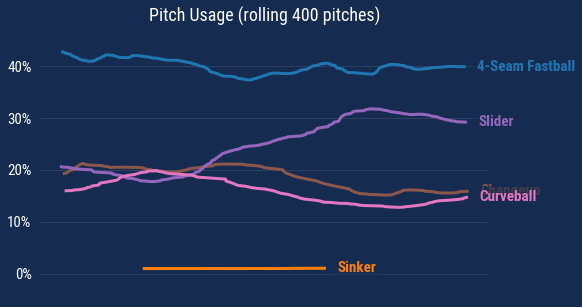

In [211]:
fig, ax = plt.subplots(figsize=(8,5))
for pitch in test_data['pitch_name'].unique():
  pitch_usage(pitch,test_data, ax,1.5, num_pitches=pitch_thresh)

686


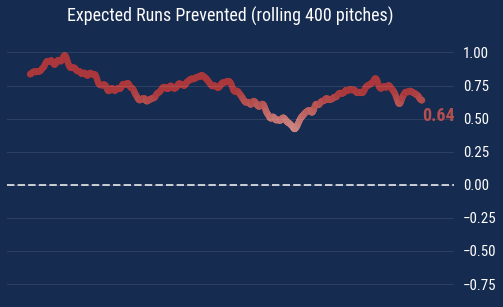

In [212]:
fig, ax = plt.subplots(figsize=(8,5))
rolling_xRP(pitch,test_data, ax,1.5, num_pitches=pitch_thresh)

### Heatmap for xRuns Prevented
very much a work-in-progress

In [ ]:
heatmap_adj = 0.5
heatmap_x_max = round(10/12+heatmap_adj,1)
heatmap_x_min = round(-10/12-heatmap_adj,1)
heatmap_y_max = 3.5+heatmap_adj
heatmap_y_min = 1.5-heatmap_adj

In [ ]:
pitch_data['h_loc_hm'] = pitch_data['h_loc'].round(1).clip(heatmap_x_min,heatmap_x_max)
pitch_data['v_loc_hm'] = pitch_data['v_loc'].round(1).clip(heatmap_y_min,heatmap_y_max)

In [ ]:
def heatmap_fuse(df,val_col,x,y,increment=0.1):
  heatmap_val = df.loc[(df['h_loc_hm']==x) & (df['v_loc_hm']==y),val_col].mean()*3/6
  neighbor_val = df.loc[((df['h_loc_hm']==max(x-increment,heatmap_x_min)) & (df['v_loc_hm']==max(y-increment,heatmap_y_min))) |
                        ((df['h_loc_hm']==max(x-increment,heatmap_x_min)) & (df['v_loc_hm']==y)) |
                        ((df['h_loc_hm']==max(x-increment,heatmap_x_min)) & (df['v_loc_hm']==min(y+increment,heatmap_y_min))) |
                        ((df['h_loc_hm']==x) & (df['v_loc_hm']==max(y-increment,heatmap_y_min))) |
                        ((df['h_loc_hm']==x) & (df['v_loc_hm']==min(y+increment,heatmap_y_min))) |
                        ((df['h_loc_hm']==max(x+increment,heatmap_x_min)) & (df['v_loc_hm']==max(y-increment,heatmap_y_min))) |
                        ((df['h_loc_hm']==max(x-increment,heatmap_x_min)) & (df['v_loc_hm']==y)) |
                        ((df['h_loc_hm']==max(x-increment,heatmap_x_min)) & (df['v_loc_hm']==min(y+increment,heatmap_y_min))),
                        val_col].mean()*2/6
  neighbor_val_1 = df.loc[((df['h_loc_hm']==max(x-increment*2,heatmap_x_min)) & (df['v_loc_hm']==max(y-increment*2,heatmap_y_min))) |
                          ((df['h_loc_hm']==max(x-increment*2,heatmap_x_min)) & (df['v_loc_hm']==max(y-increment,heatmap_y_min))) |
                          ((df['h_loc_hm']==max(x-increment*2,heatmap_x_min)) & (df['v_loc_hm']==y)) |
                          ((df['h_loc_hm']==max(x-increment*2,heatmap_x_min)) & (df['v_loc_hm']==min(y+increment,heatmap_y_min))) |
                          ((df['h_loc_hm']==max(x-increment*2,heatmap_x_min)) & (df['v_loc_hm']==min(y+increment*2,heatmap_y_min))) |
                          ((df['h_loc_hm']==max(x-increment,heatmap_x_min)) & (df['v_loc_hm']==max(y-increment*2,heatmap_y_min))) |
                          ((df['h_loc_hm']==max(x-increment,heatmap_x_min)) & (df['v_loc_hm']==min(y+increment*2,heatmap_y_min))) |
                          ((df['h_loc_hm']==x) & (df['v_loc_hm']==max(y-increment*2,heatmap_y_min))) |
                          ((df['h_loc_hm']==x) & (df['v_loc_hm']==min(y+increment*2,heatmap_y_min))) |
                          ((df['h_loc_hm']==min(x+increment,heatmap_x_max)) & (df['v_loc_hm']==max(y-increment*2,heatmap_y_min))) |
                          ((df['h_loc_hm']==min(x+increment,heatmap_x_max)) & (df['v_loc_hm']==min(y+increment*2,heatmap_y_min))) |
                          ((df['h_loc_hm']==min(x+increment*2,heatmap_x_max)) & (df['v_loc_hm']==max(y-increment*2,heatmap_y_min))) |
                          ((df['h_loc_hm']==min(x+increment*2,heatmap_x_max)) & (df['v_loc_hm']==max(y-increment,heatmap_y_min))) |
                          ((df['h_loc_hm']==min(x+increment*2,heatmap_x_max)) & (df['v_loc_hm']==y)) |
                          ((df['h_loc_hm']==min(x+increment*2,heatmap_x_max)) & (df['v_loc_hm']==min(y+increment,heatmap_y_min))) |
                          ((df['h_loc_hm']==min(x+increment*2,heatmap_x_max)) & (df['v_loc_hm']==min(y+increment*2,heatmap_y_min))),
                          val_col].mean()/6
  return heatmap_val+neighbor_val+neighbor_val_1

In [ ]:
#test_data = pitch_data.loc[pitch_data['player_name']=='Justin Verlander'].copy()
#heatmap_plot = pd.DataFrame()
#
#for x in range(int((heatmap_x_min*10)),int((heatmap_x_max*10))+1):
#  for y in range(int((heatmap_y_min*10)),int((heatmap_y_max*10))+1):
#    heatmap_plot = heatmap_plot.append({'x':x/10,'y':y/10}, ignore_index=True)
#
#for x in range(int((heatmap_x_min*10)),int((heatmap_x_max*10))+1):
#  for y in range(int((heatmap_y_min*10)),int((heatmap_y_max*10))+1):
#    heatmap_plot.loc[(heatmap_plot['x']==x/10) & (heatmap_plot['y']==y/10),'xRP'] = heatmap_fuse(test_data,'xRuns_prevented',x/10,y/10)
#heatmap_plot['xRP'] = heatmap_plot['xRP'].fillna(0)
#
#fig, ax = plt.subplots(figsize=(6.5,7.5))
#sns.heatmap(data=heatmap_plot.pivot('y','x','xRP'),
#            vmin=-pitch_data['xRuns_prevented'].quantile(0.75),
#            center=0,
#            vmax=pitch_data['xRuns_prevented'].quantile(0.75),
#            cmap='vlag',
#            mask=(abs(heatmap_plot.pivot('y','x','xRP'))<=0),
#            cbar=False
#            )
#
#ax.set(xlabel=None, ylabel=None, aspect=1)
#ax.axvline(5, ymin=1/6, ymax=5/6, color='black', linewidth=8)
#ax.axvline(22, ymin=1/6, ymax=5/6, color='black', linewidth=8)
#ax.axhline(5, xmin=5/26-0.0075, xmax=21/26+0.0075, color='black', linewidth=8)
#ax.axhline(26, xmin=5/26-0.0075, xmax=21/26+0.0075, color='black', linewidth=8)
#
#ax.set_xticklabels([])
#ax.set_yticklabels([])
#ax.tick_params(left=False, bottom=False)
#
#ax.invert_yaxis()
#sns.despine(left=True,bottom=True)

## Player Card Functions

In [ ]:
# General cutoff for sample (affects all the percentile calcs/bullet charts)
pitch_count_threshold = int(pitch_data['season_pitch_count'].quantile(1/4))
pitch_count_threshold

419

In [ ]:
def xRP_card(player_name_lookup,time_frame='year',pitch_threshold=pitch_count_threshold,scale_val=1.5):
  # Basic name lookup, to match partial names
  pitcher_name = (
      pitch_data
      .loc[pitch_data['player_name']
           .str
           .contains(player_name_lookup),
           'player_name']
      .unique()[0]
      )
  
  # Create df for only the pitcher's pitches
  graph_data = pitch_data.loc[pitch_data['player_name']==pitcher_name].iloc[::-1].copy().reset_index(drop=True)
  game_date = graph_data['game_date'].max()
  graph_data = graph_data if time_frame=='year' else graph_data.loc[graph_data['game_date']==game_date]
  graph_data['pitch_type_freq'] = (rolling_count(graph_data['pitch_name'],100)+1)/100

  # Update the pitch count threshold if the pitcher has a low season pitch count
  pitch_threshold = min(pitch_threshold,graph_data.shape[0])

  # Generate data for bullet charts
  # Strikeouts and Walks need their own, as they're conditional
  bullet_df = bullet_data(pitch_data,time_frame,game_date,pitch_threshold)

  strikeout_df = pitch_data.loc[pitch_data['strikes']==2,['player_name','game_date','called_strike_pred_p','swinging_strike_pred_p']]
  strikeout_df['strikeout_pred'] = strikeout_df[['called_strike_pred_p','swinging_strike_pred_p']].sum(axis=1)
  strikeout_df = strikeout_df.groupby(['player_name'] if time_frame == 'year' else ['player_name','game_date'],as_index=False)['strikeout_pred'].mean().sort_values('strikeout_pred',ascending=False)
  strikeout_df = strikeout_df.merge(pitch_data.groupby(['player_name'] if time_frame == 'year' else ['player_name','game_date'],as_index=False)['pitch_name'].agg({
      'pitch_name':'count'
  }).sort_values('pitch_name', ascending=False).rename(columns={'pitch_name':'pitch_count'}),how='left', on=['player_name'] if time_frame == 'year' else ['player_name','game_date'])
  strikeout_df = strikeout_df.loc[strikeout_df['pitch_count']>=pitch_threshold]
  strikeout_df['strikeout_percentile'] = strikeout_df['strikeout_pred'].rank(pct=True).round(2)
  strikeout_df = strikeout_df if time_frame == 'year' else strikeout_df.loc[strikeout_df['game_date']==game_date]

  walk_df = pitch_data.loc[pitch_data['balls']==3,['player_name','game_date','ball_pred_p']].rename(columns={'ball_pred_p':'walk_pred'})
  walk_df = walk_df.groupby(['player_name'] if time_frame == 'year' else ['player_name','game_date'],as_index=False)['walk_pred'].mean().sort_values('walk_pred',ascending=False)
  walk_df = walk_df.merge(pitch_data.groupby(['player_name'] if time_frame == 'year' else ['player_name','game_date'],as_index=False)['pitch_name'].agg({
      'pitch_name':'count'
  }).sort_values('pitch_name', ascending=False).rename(columns={'pitch_name':'pitch_count'}),how='left', on=['player_name'] if time_frame == 'year' else ['player_name','game_date'])
  walk_df = walk_df.loc[walk_df['pitch_count']>=pitch_threshold]
  walk_df['walk_percentile'] = round(1-walk_df['walk_pred'].rank(pct=True),2)
  walk_df = walk_df if time_frame == 'year' else walk_df.loc[walk_df['game_date']==game_date]

  # Card size
  fig = plt.figure(figsize=(7.5*scale_val,10.5*scale_val))

  # Parameters to divide card
  grid_height = 10
  pitch_feats = 8

  # Divide card into tiles
  grid = plt.GridSpec(grid_height, 7, wspace=0.1*scale_val, hspace=0.5*scale_val, width_ratios=[2.5,0.6,4.4,1.5,0.5,0.25,0.25],
                      height_ratios=[1.5]+[7/pitch_feats]*(pitch_feats)+[1])

  # Title of card (name, etc)
  title_ax = plt.subplot(grid[0, :3])
  title_ax.text(0,0,"{}'s 2022\nExpected Runs Prevented (xRP) Card\nxRP per 100 Pitches: {}".format(pitcher_name,round(graph_data['xRuns_prevented'].mean() * 100,2)), ha='center', va='center', fontsize=round(16*scale_val),
           bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  title_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  title_ax.set_xticklabels([])
  title_ax.set_yticklabels([])
  title_ax.tick_params(left=False, bottom=False)

  # xRP Bullet
  xRP_ax = plt.subplot(grid[1, 0])
  xRP_ax.set_xticklabels([])
  xRP_ax.set_yticklabels([])
  xRP_ax.tick_params(left=False, bottom=False)
  xRP_ax.set_title('xRP per Pitch', fontsize=int(12*scale_val))
  bullet_chart(bullet_df, pitcher_name,xRP_ax,'xRP_percentile',scale_val)

  # Stuff Bullet
  stuff_ax = plt.subplot(grid[2, 0])
  stuff_ax.set_xticklabels([])
  stuff_ax.set_yticklabels([])
  stuff_ax.tick_params(left=False, bottom=False)
  stuff_ax.set_title('Stuff', fontsize=int(12*scale_val))
  bullet_chart(bullet_df, pitcher_name,stuff_ax,'stuff_percentile',scale_val)

  # Location Bullet
  location_ax = plt.subplot(grid[3, 0])
  location_ax.set_xticklabels([])
  location_ax.set_yticklabels([])
  location_ax.tick_params(left=False, bottom=False)
  location_ax.set_title('Location', fontsize=int(12*scale_val))
  bullet_chart(bullet_df, pitcher_name,location_ax,'command_percentile',scale_val)

  # xK% Bullet
  xK_ax= plt.subplot(grid[4, 0])
  xK_ax.set_xticklabels([])
  xK_ax.set_yticklabels([])
  xK_ax.tick_params(left=False, bottom=False)
  xK_ax.set_title('xK%', fontsize=int(12*scale_val))
  bullet_chart(strikeout_df, pitcher_name,xK_ax,'strikeout_percentile',scale_val)

  # xBB% Bullet
  xBB_ax= plt.subplot(grid[5, 0])
  xBB_ax.set_xticklabels([])
  xBB_ax.set_yticklabels([])
  xBB_ax.tick_params(left=False, bottom=False)
  xBB_ax.set_title('xBB%', fontsize=int(12*scale_val))
  bullet_chart(walk_df, pitcher_name,xBB_ax,'walk_percentile',scale_val)

  # xCSW Bullet
  csw_ax = plt.subplot(grid[6, 0])
  csw_ax.set_xticklabels([])
  csw_ax.set_yticklabels([])
  csw_ax.tick_params(left=False, bottom=False)
  csw_ax.set_title('xCSW', fontsize=int(12*scale_val))
  bullet_chart(bullet_df, pitcher_name,csw_ax,'csw_percentile',scale_val)

  # xGB% Bullet
  gb_ax = plt.subplot(grid[7, 0])
  gb_ax.set_xticklabels([])
  gb_ax.set_yticklabels([])
  gb_ax.tick_params(left=False, bottom=False)
  gb_ax.set_title('xGB%', fontsize=int(12*scale_val))
  bullet_chart(bullet_df, pitcher_name,gb_ax,'gb_percentile',scale_val)

  # xHR Bullet
  home_run_ax = plt.subplot(grid[8, 0])
  home_run_ax.set_xticklabels([])
  home_run_ax.set_yticklabels([])
  home_run_ax.tick_params(left=False, bottom=False)
  home_run_ax.set_title('xHR%', fontsize=int(12*scale_val))
  bullet_chart(bullet_df, pitcher_name, home_run_ax,'home_run_percentile',scale_val)

  # Line with descriptors to show color scheme
  scale_ax = plt.subplot(grid[9, 0])
  scale_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  scale_ax.axhline(0.9, xmin=.1, xmax=.9, color='w', linewidth=int(2*scale_val))
  scale_ax.set_xticklabels([])
  scale_ax.set_yticklabels([])
  scale_ax.tick_params(left=False, bottom=False)
  scale_ax.text(-0.69,0,'Poor', ha='center', va='center', fontweight='bold', fontsize=int(12*scale_val), color='#4075bf')
  scale_ax.text(0,0,'Avg', ha='center', va='center', fontweight='bold', fontsize=int(12*scale_val), color='#FEFEFE')
  scale_ax.text(0.7,0,'Great', ha='center', va='center', fontweight='bold', fontsize=int(12*scale_val), color='#bf4640')

  # Per game/appearance chart
  game_ax = plt.subplot(grid[1:4, 2:6])
  game_ax.grid(visible=True, which='major', axis='y', color='#FEFEFE', alpha=0.1)

  graph_data['appearance'] = graph_data['game_date'].rank(method='dense')

  # Subtle line to connect the dots
  sns.lineplot(
      data=graph_data.groupby(['game_date','player_name'],as_index=False)[['xRuns_prevented','appearance']].agg({
          'xRuns_prevented':'sum',
          'appearance': 'mean'
          }), 
      x='game_date', 
      y='xRuns_prevented',
      style='player_name',
      color='#FEFEFE',
      linewidth=round(scale_val),
      alpha=0.1,
      ax=game_ax,
      legend=False)

  # Dots
  sns.scatterplot(
      data=graph_data.groupby('game_date',as_index=False)[['xRuns_prevented','appearance']].agg({
          'xRuns_prevented':'sum',
          'appearance': 'mean'
          }), 
      x='game_date', 
      y='xRuns_prevented', 
      s=round(100*scale_val), 
      edgecolor=None, 
      hue='xRuns_prevented', 
      hue_norm=game_norm, 
      palette='vlag', 
      alpha=1,
      ax=game_ax,
      legend=False)

  # League Average line
  game_ax.axhline(0, color='#FEFEFE', linewidth=round(scale_val), linestyle='--', alpha=0.75)
  # General Descriptors (location changes dynamically, based on timeframe)
  game_ax.text(x=graph_data['game_date'].max()+pd.Timedelta(days=((graph_data['game_date'].max() - graph_data['game_date'].min())/12).days),y=min_app_xRP+0.25,s='Poor', ha='left', va='center', fontsize=int(12*scale_val), color='#4075bf', fontweight='bold', bbox=dict(facecolor='#162B50', alpha=0.3, edgecolor='#162B50'))
  game_ax.text(x=graph_data['game_date'].max()+pd.Timedelta(days=((graph_data['game_date'].max() - graph_data['game_date'].min())/12).days),y=0,s='Avg', ha='left', va='center', fontsize=int(12*scale_val), color='#FEFEFE', fontweight='bold', bbox=dict(facecolor='#162B50', alpha=0.3, edgecolor='#162B50'))
  game_ax.text(x=graph_data['game_date'].max()+pd.Timedelta(days=((graph_data['game_date'].max() - graph_data['game_date'].min())/12).days),y=max_app_xRP-0.25,s='Great', ha='left', va='center', fontsize=int(12*scale_val), color='#bf4640', fontweight='bold', bbox=dict(facecolor='#162B50', alpha=0.3, edgecolor='#162B50'))

  game_ax.set(xlabel=None, ylabel=None, ylim=(min_app_xRP-0.25,max_app_xRP+0.25))
  x_ticks_format(game_ax,graph_data['game_date'],scale_val)
  game_ax.set_title('Expected Runs Prevented, per Game', fontsize=round(12*scale_val))

  # Usage chart (not included)
  #usage_ax = plt.subplot(grid[3, 2:6])
  #for pitch_type in graph_data.sort_values('avg_velo',ascending=False)['pitch_name'].unique():
  #  pitch_usage(pitch_type,graph_data,usage_ax,scale_val)

  # Plot of individual pitches
  pitch_plot_ax = plt.subplot(grid[4:, 1:5])
  sns.scatterplot(data=graph_data.loc[(graph_data['adj_v_loc']<=y_lim-0.25)&
                                      (graph_data['h_loc']>-2.8)], 
                  x='h_loc', 
                  y='adj_v_loc', 
                  s=round(70*scale_val), 
                  style='pitch_name',
                  hue='xRuns_prevented',
                  palette='vlag',
                  hue_norm=norm,
                  markers=marker_list,
                  edgecolor='#293a6b',
#                  linewidth=0.5,
                  ax=pitch_plot_ax,
                  legend=False
                  )

  # Strike zone outline
  pitch_plot_ax.axvline(10/12, ymin=(sz_bot-y_bot)/(y_lim-y_bot), ymax=(sz_top-y_bot)/(y_lim-y_bot), color='black', linewidth=4*scale_val)
  pitch_plot_ax.axvline(-10/12, ymin=(sz_bot-y_bot)/(y_lim-y_bot), ymax=(sz_top-y_bot)/(y_lim-y_bot), color='black', linewidth=4*scale_val)
  pitch_plot_ax.axhline(sz_top, xmin=26/72, xmax=46/72, color='black', linewidth=4*scale_val)
  pitch_plot_ax.axhline(sz_bot, xmin=26/72, xmax=46/72, color='black', linewidth=4*scale_val)

  pitch_plot_ax.set(xlabel=None, xlim=(-3,3), ylabel=None, ylim=(y_bot,y_lim))
  pitch_plot_ax.set_xticklabels([])
  pitch_plot_ax.set_yticklabels([])
  pitch_plot_ax.tick_params(left=False, bottom=False)
  pitch_plot_ax.text(0.75,y_lim-0.6,"Expected Runs Prevented per Pitch", ha='center', va='bottom', fontsize=round(12*scale_val), 
           bbox=dict(facecolor='#162B50', alpha=0.75, edgecolor='#162B50'))
  pitch_plot_ax.text(0.75,y_lim-0.7,"(From Catcher's Perspective)", ha='center', va='top', fontsize=round(10*scale_val), alpha=0.7,
           bbox=dict(facecolor='#162B50', alpha=0.75, edgecolor='#162B50'))

  # Add custom legend for markers
  legend_markers = [Line2D([],[],
                           color='#FEFEFE',
                           label='\n'.join(wrap(x, 10)),
                           marker=marker_list[x],
                           markeredgecolor=pl_line_color,
                           markeredgewidth=round(scale_val),
                           markersize=round(10*scale_val),
                           linestyle='None') 
                    for x in graph_data.sort_values('avg_velo',ascending=False)['pitch_name'].unique()]

  pitch_plot_ax.legend(loc=(0.01,0.01),
             handles=legend_markers,
             edgecolor='#162B50',
             framealpha=0.5, fontsize=round(12*scale_val)
             )

  # Colorbar for pitch plot
  cb_ax = plt.subplot(grid[5:9, 5])
  sm = plt.cm.ScalarMappable(cmap='vlag', norm=norm)
  sm.set_array([])
  fig.colorbar(sm,
               cax=cb_ax
               )
  cb_ax.tick_params(labelsize=round(10*scale_val))
  
  # Chart ownership (that's me!)
  owner_ax = plt.subplot(grid[0, 3:])
  owner_ax.text(0.5,0,'Created by Kyle Bland\n@blandalytics', ha='center', va='center',fontweight='normal', fontsize=round(12*scale_val),
            bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  owner_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  owner_ax.set_xticklabels([])
  owner_ax.set_yticklabels([])
  owner_ax.tick_params(left=False, bottom=False)

  # Credit for the inspiration
  credit_ax = plt.subplot(grid[9:, 5:])
  credit_ax.text(-0.1,0.5,'Inspired by\n@Pitching_Bot +\nBaseball Savant', ha='center', va='center', fontsize=round(10*scale_val),
           bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  credit_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  credit_ax.set_xticklabels([])
  credit_ax.set_yticklabels([])
  credit_ax.tick_params(left=False, bottom=False)

  # Box the Bullet Charts
  fig.add_artist(Line2D([0.125, 0.302], [0.8, 0.8], linewidth=round(2*scale_val)))
  fig.add_artist(Line2D([0.125, 0.125], [0.125, 0.8], linewidth=round(2*scale_val)))
  fig.add_artist(Line2D([0.302, 0.302], [0.125, 0.8], linewidth=round(2*scale_val)))
  fig.add_artist(Line2D([0.125, 0.302], [0.125, 0.125], linewidth=round(2*scale_val)))

  #Box the starts
  fig.add_artist(Line2D([0.32, 0.94], [0.8, 0.8], linewidth=round(2*scale_val))) # Top
  fig.add_artist(Line2D([0.32, 0.32], [0.546, 0.8], linewidth=round(2*scale_val))) # Left
  fig.add_artist(Line2D([0.94, 0.94], [0.546, 0.8], linewidth=round(2*scale_val))) # Right
  fig.add_artist(Line2D([0.32, 0.94], [0.546, 0.546], linewidth=round(2*scale_val))) # Bottom

  #Box the pitch chart
  fig.add_artist(Line2D([0.32, 0.94], [0.536, 0.536], linewidth=round(2*scale_val)))
  fig.add_artist(Line2D([0.32, 0.32], [0.125, 0.536], linewidth=round(2*scale_val)))
  fig.add_artist(Line2D([0.94, 0.94], [0.125, 0.536], linewidth=round(2*scale_val)))
  fig.add_artist(Line2D([0.32, 0.94], [0.125, 0.125], linewidth=round(2*scale_val)))

  sns.despine(left=True, bottom=True)

In [ ]:
def xRP_pitch_card(player_name_lookup,pitch_threshold_percent=0.05,scale_val=1.5):
  pitcher_name = (
      pitch_data
      .loc[pitch_data['player_name']
           .str
           .contains(player_name_lookup),
           'player_name']
      .unique()[0]
      )
  
  graph_data = pitch_data.loc[pitch_data['player_name'].str.contains(pitcher_name)].iloc[::-1].copy().reset_index(drop=True)
  graph_data = graph_data.merge(graph_data.groupby(['player_name','pitch_name'],as_index=False)['pitch_type'].agg({
      'pitch_type':'count'
  }).rename(columns={'pitch_type':'pitch_count'}),how='left', on=['player_name','pitch_name'])
  graph_data['pitch_type_freq'] = (rolling_count(graph_data['pitch_name'],100)+1)/100
  game_date = graph_data['game_date'].max()
  
  pitch_threshold = int(pitch_threshold_percent*min(pitch_count_threshold,graph_data.shape[0]))

  num_pitches = min(5,len(list(graph_data.loc[(graph_data['player_name']==pitcher_name) &
                                              (graph_data['pitch_count']>pitch_threshold),'pitch_name'].unique())))
  pitch_list = (
      list(graph_data
           .loc[(graph_data['player_name']==pitcher_name) &
                (graph_data['pitch_count']>pitch_threshold)]
           .groupby('pitch_name', as_index=False)[['pitch_count','avg_velo']]
           .mean()
           .sort_values('pitch_count',ascending=False)[:num_pitches].sort_values('avg_velo',ascending=False)['pitch_name']))

  # Generate data for bullet charts
  bullet_df = pitch_bullet_data(pitch_data,pitch_threshold)

  fig = plt.figure(figsize=(7.5*scale_val,10.5*scale_val))

  pitch_feats = 4

  # Grid layout is based on the number of pitches a pitcher throws (num_pitches)
  grid = plt.GridSpec(9, num_pitches*2, wspace=0.01*scale_val, hspace=0.4*scale_val,
                      height_ratios=[2,1]+[3/pitch_feats]*pitch_feats+[0.2,3,3])

  title_ax = plt.subplot(grid[0, :-2 if num_pitches>2 else -1])
  title_ax.text(0,-0.25,"{}'s 2022\nPitch Analysis Card".format(pitcher_name), ha='center', va='center', fontsize=round(16*scale_val),
           bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  title_ax.text(0,-1.25,"(Compared to pitches of same type; ≥{}% Pitches Thrown)".format(int(pitch_threshold_percent*100)), ha='center', va='center', fontsize=round(10*scale_val), alpha=0.7,
           bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  title_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1.5,1))
  title_ax.set_xticklabels([])
  title_ax.set_yticklabels([])
  title_ax.tick_params(left=False, bottom=False)

  # Dynamically changing strike zone (for different num_pitches; done by trial and error. Works for 2-5 pitches)
  y_lim = 3.5+(num_pitches**3)/200
  y_bot = 1-(num_pitches**3)/200
  x_scale = 2+8/(num_pitches**3)

  # Median plate location of each pitch type, to plot movement
  movement_avgs = (
      graph_data
      .loc[(graph_data['adj_v_loc']<=y_lim-0.25) &
           (graph_data['h_loc']>-2.8)]
           .groupby('pitch_name')
           [['vx0','vy0','vz0','ax','ay','az','release_pos_x',
             'release_pos_y','release_pos_z','h_move','v_move',
             'h_loc','adj_v_loc']]
             .median()
             .to_dict(orient='index')
  )

  # Title for pitch locations
  plot_title_ax = plt.subplot(grid[6, :])
  plot_title_ax.text(0,1,"Pitch Locations, From Catcher's Perspective", ha='center', va='center', fontsize=round(14*scale_val),
           bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  plot_title_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  plot_title_ax.set_xticklabels([])
  plot_title_ax.set_yticklabels([])
  plot_title_ax.tick_params(left=False, bottom=False)

  for pitch_type in pitch_list:
    grid_start = list(pitch_list).index(pitch_type)*2
    grid_end = (list(pitch_list).index(pitch_type)+1)*2
    bullet_df = pitch_bullet_data(pitch_data,pitch_threshold,pitch_type=pitch_type)

    percent_text = '({}%; Last: {}%)'.format(int(max(0.05,graph_data.loc[graph_data['pitch_name']==pitch_type].shape[0]/graph_data.shape[0])*100),
                                                   int(graph_data.loc[(graph_data['pitch_name']==pitch_type) & 
                                                                      (graph_data['game_date']==graph_data['game_date'].max())].shape[0]/graph_data.loc[graph_data['game_date']==graph_data['game_date'].max()].shape[0]*100))

    # Pitch type title
    pitch_ax = plt.subplot(grid[1, grid_start:grid_end])
    pitch_ax.text(0,-0.3,'\n'.join(wrap(pitch_type, 10)), ha='center', va='bottom', fontsize=round(16*scale_val),
             bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
    pitch_ax.text(0,-0.5,percent_text, ha='center', va='top', fontsize=round(10*scale_val), alpha=0.7,
             bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
    pitch_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
    pitch_ax.set_xticklabels([])
    pitch_ax.set_yticklabels([])
    pitch_ax.tick_params(left=False, bottom=False)

    #usage_ax = plt.subplot(grid[2:4, grid_start:grid_end])
    #pitch_usage(pitch_type,graph_data,usage_ax,scale_val)

    stuff_ax = plt.subplot(grid[2, grid_start:grid_end])
    stuff_ax.set_xticklabels([])
    stuff_ax.set_yticklabels([])
    stuff_ax.tick_params(left=False, bottom=False)
    stuff_ax.set_title('Stuff', fontsize=int(12*scale_val))
    bullet_chart(bullet_df, pitcher_name,stuff_ax,'stuff_percentile',1.4)

    csw_ax = plt.subplot(grid[3, grid_start:grid_end])
    csw_ax.set_xticklabels([])
    csw_ax.set_yticklabels([])
    csw_ax.tick_params(left=False, bottom=False)
    csw_ax.set_title('xCSW', fontsize=int(12*scale_val))
    bullet_chart(bullet_df, pitcher_name,csw_ax,'csw_percentile',1.4)

    gb_ax = plt.subplot(grid[4, grid_start:grid_end])
    gb_ax.set_xticklabels([])
    gb_ax.set_yticklabels([])
    gb_ax.tick_params(left=False, bottom=False)
    gb_ax.set_title('xGB%', fontsize=int(12*scale_val))
    bullet_chart(bullet_df, pitcher_name,gb_ax,'gb_percentile',1.4)

    home_run_ax = plt.subplot(grid[5, grid_start:grid_end])
    home_run_ax.set_xticklabels([])
    home_run_ax.set_yticklabels([])
    home_run_ax.tick_params(left=False, bottom=False)
    home_run_ax.set_title('xHR%', fontsize=int(12*scale_val))
    bullet_chart(bullet_df, pitcher_name, home_run_ax,'home_run_percentile',1.4)

    # Pitch location plot
    pitch_plot_ax = plt.subplot(grid[7, grid_start:grid_end])
    sns.kdeplot(data=graph_data.loc[(graph_data['adj_v_loc']<=y_lim-0.25) &
                                        (graph_data['h_loc']>-2.8) &
                                        (graph_data['pitch_name']==pitch_type)], 
                x='h_loc',
                y='adj_v_loc',
                levels=8,
                fill=True,
                alpha=0.75,
                cmap='vlag',
                ax=pitch_plot_ax,
                thresh=0.6,
                cbar=False
                )
    
    # Strike Zone outline
    pitch_plot_ax.axhline(sz_bot, xmin=(12*x_scale-10)/(24*x_scale), xmax=(12*x_scale+10)/(24*x_scale), color='black', linewidth=2*scale_val)
    pitch_plot_ax.axvline(10/12, ymin=(sz_bot-y_bot)/(y_lim-y_bot), ymax=(sz_top-y_bot)/(y_lim-y_bot), color='black', linewidth=2*scale_val)
    pitch_plot_ax.axvline(-10/12, ymin=(sz_bot-y_bot)/(y_lim-y_bot), ymax=(sz_top-y_bot)/(y_lim-y_bot), color='black', linewidth=2*scale_val)
    pitch_plot_ax.axhline(sz_top, xmin=(12*x_scale-10)/(24*x_scale), xmax=(12*x_scale+10)/(24*x_scale), color='black', linewidth=2*scale_val)
    
    pitch_plot_ax.set(xlabel=None, xlim=(-x_scale,x_scale), ylabel=None, ylim=(y_bot,y_lim))
    pitch_plot_ax.set_xticklabels([])
    pitch_plot_ax.set_yticklabels([])
    pitch_plot_ax.tick_params(left=False, bottom=False)

  # Velocity chart
  velo_ax = plt.subplot(grid[8,:-num_pitches])
  velo_ax.set_title('Pitch Velocities', fontsize=int(12*1.5))
  sns.violinplot(data=graph_data.loc[(graph_data['player_name']==pitcher_name) &
                                     (graph_data['velocity']>=graph_data['velocity'].quantile(0.005)) &
                                     (graph_data['pitch_name'].isin(pitch_list)),
                                     ['player_name','pitch_name','velocity','avg_velo']].copy().sort_values('avg_velo',ascending=False), 
                 x='velocity', y='pitch_name', palette=marker_colors, inner=None, orient='h', alpha=1, linewidth=0.5, scale='count', cut=0, ax=velo_ax)
  
  velo_min = pitch_data['velocity'].quantile(0.01)
  for plot in velo_ax.collections:
    plot.set_edgecolor(pl_white)
  velo_ax.tick_params(axis='y', labelsize=int(12*1.5))
  velo_ax.tick_params(left=False, bottom=False)
  velo_ax.set(xlabel=None, xlim=(min(velo_min,int((graph_data.loc[graph_data['player_name']==pitcher_name,'velocity'].quantile(0.01))/5)*5-2*scale_val), pitch_data['velocity'].max()), ylabel=None)
  velo_ax.set_xticklabels([str(int(x)) if x!=100 else str(int(x))+'mph' for x in velo_ax.get_xticks()], ha='left', fontsize=int(12*1.5))
  velo_ax.set_yticklabels([])
  velo_ax.grid(True, 'major','x',linestyle='--', alpha=0.5, color='#b3b3b3', linewidth=round(scale_val))
  velo_ax.text(min(velo_min,int((graph_data.loc[graph_data['player_name']==pitcher_name,'velocity'].quantile(0.01))/5)*5-2*scale_val)+5,0,'= MLB Avg', ha='left', va='center', fontsize=int(10*scale_val), color='#FEFEFE', bbox=dict(facecolor='#162B50', alpha=0.7, edgecolor='#162B50'))
  # Label for if plotting Last Appearance values
#  velo_ax.text(pitch_data['velocity'].max()-2,num_pitches-1,'Last Game =', ha='right', va='center', fontsize=int(10*scale_val), color='#c23230', bbox=dict(facecolor='#162B50', alpha=0.7, edgecolor='#162B50'))

  for pitch_type in pitch_list:
    pitch_num = list(pitch_list).index(pitch_type)
    velo_ax.axvline(pitch_data.loc[pitch_data['pitch_name']==pitch_type,'velocity'].mean(), ymin=(num_pitches-0.8-pitch_num)/(num_pitches), ymax=(num_pitches-0.2-pitch_num)/(num_pitches), color='#FEFEFE', linewidth=round(scale_val))
  # Lines for plotting Last Appearance values
#    velo_ax.axvline(graph_data.loc[(graph_data['pitch_name']==pitch_type) & 
#                                   (graph_data['game_date']==graph_data['game_date'].max()),'velocity'].mean(), ymin=(num_pitches-0.8-pitch_num)/(num_pitches), ymax=(num_pitches-0.2-pitch_num)/(num_pitches), color='#c23230', linewidth=round(2*scale_val))

  velo_ax.axvline(min(velo_min,int((graph_data.loc[graph_data['player_name']==pitcher_name,'velocity'].quantile(0.01))/5)*5-2*scale_val)+4, ymin=(num_pitches-0.8)/(num_pitches), ymax=(num_pitches-0.2)/(num_pitches), color='#FEFEFE', linewidth=round(scale_val))
  # Last Appearance label line
#  velo_ax.axvline(pitch_data['velocity'].max()-1, ymin=(0.2)/(num_pitches), ymax=(0.8)/(num_pitches), color='#c23230', linewidth=round(2*scale_val))
    
  pitch_label_ax = plt.subplot(grid[8,-max(3,num_pitches-1) if num_pitches >2 else -2:-max(2,num_pitches-2) if num_pitches >2 else -1])
  
  # Add custom legend for markers
  legend_markers = [Line2D([],[],
                           color=marker_colors[x],
                           label='\n'.join(wrap(x, 12)),
                           marker=marker_list[x],
                           markersize=round(10*scale_val),
                           markeredgecolor=pl_white,
                           linestyle='None') 
                    for x in pitch_list]
  label_spacing = {
      2:7/2,
      3:9/5,
      4:1,
      5:7/10
  }

  pitch_label_ax.legend(loc='center' if num_pitches <4 else 'center right',
                        handles=legend_markers,
                        edgecolor='#162B50',
                        labelspacing=label_spacing[num_pitches],
                        framealpha=0, fontsize=round(10*scale_val)
                        )
  pitch_label_ax.set_xticklabels([])
  pitch_label_ax.set_yticklabels([])
  pitch_label_ax.tick_params(left=False, bottom=False)

  # Dynamically change chart/strike zone values for num_pitches
  x_scale = 3+(num_pitches/(num_pitches+1))

  movement_ax = plt.subplot(grid[8,-max(2,num_pitches-2) if num_pitches >2 else -1:])
  x_lim_min = min(-x_scale,graph_data.groupby('pitch_name')['release_pos_x'].median().min()-0.5)
  x_lim_max = max(x_scale,graph_data.groupby('pitch_name')['release_pos_x'].median().max()+0.5)
  y_lim_min = min(1.4,graph_data.groupby('pitch_name')['v_loc'].median().min()-0.1)
  y_lim_max = 7

  x_lim_min = x_lim_min if ((x_lim_max-x_lim_min) > (y_lim_max-y_lim_min)) else x_lim_min * ((y_lim_max-y_lim_min)/(x_lim_max-x_lim_min))
  x_lim_max = x_lim_max if ((x_lim_max-x_lim_min) > (y_lim_max-y_lim_min)) else x_lim_max * ((y_lim_max-y_lim_min)/(x_lim_max-x_lim_min))

  sz_adj_min = (-x_lim_min*12-10) / ((x_lim_max-x_lim_min)*12)
  sz_adj_max = sz_adj_min+20/((x_lim_max-x_lim_min)*12)

  movement_ax.axhline(sz_bot, xmin=sz_adj_min, xmax=sz_adj_max, color='black', linewidth=2*scale_val)

  for pitch in list(pitch_list)[::-1]:
    movement_plot(pitch,
                  movement_avgs,
                  movement_ax, 
                  marker_colors[pitch])

  movement_ax.axhline(sz_top, xmin=sz_adj_min, xmax=sz_adj_max, color='black', linewidth=2*scale_val)
  movement_ax.axvline(10/12 if graph_data['p_hand'].unique()[0]=='R' else -10/12, ymin=(sz_bot-y_lim_min)/(y_lim_max-y_lim_min), ymax=(sz_top-y_lim_min)/(y_lim_max-y_lim_min), color='black', linewidth=2*scale_val)
  movement_ax.axvline(-10/12 if graph_data['p_hand'].unique()[0]=='R' else 10/12, ymin=(sz_bot-y_lim_min)/(y_lim_max-y_lim_min), ymax=(sz_top-y_lim_min)/(y_lim_max-y_lim_min), color='black', linewidth=2*scale_val)

  movement_ax.set(xlim=(x_lim_min,x_lim_max), ylim=(y_lim_min,y_lim_max))
  movement_ax.set_title("Pitch Movement", fontsize=round(12*scale_val))
  movement_ax.set_xticklabels([])
  movement_ax.set_yticklabels([])
  movement_ax.tick_params(left=False, bottom=False)

  owner_ax = plt.subplot(grid[0, -2 if num_pitches>2 else -1:])
  owner_ax.text(0,0,'Created by Kyle Bland\n@blandalytics', ha='center', va='center',fontweight='normal', fontsize=round(12*scale_val),
            bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  owner_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  owner_ax.set_xticklabels([])
  owner_ax.set_yticklabels([])
  owner_ax.tick_params(left=False, bottom=False)

  # Add lines between pitches
  line_spacing = {
      2:[0.51,0],
      3:[0.38,0.26],
      4:[0.32,0.194],
      5:[0.28,0.155]
  }

  for x in range(0,len(pitch_list)-1):
    line_x = line_spacing[len(pitch_list)][0]+line_spacing[len(pitch_list)][1]*x
    fig.add_artist(Line2D([line_x, line_x], [0.48, 0.69], linewidth=round(2*scale_val)))

  #Box the plots
  left_right_lim = {
      2:[0.13,0.89],
      3:[0.13,0.89],
      4:[0.13,0.89],
      5:[0.13,0.91]
  }

  left_lim = left_right_lim[len(pitch_list)][0]
  right_lim = left_right_lim[len(pitch_list)][1]

  #Box the Pitch Locations
  fig.add_artist(Line2D([left_lim, 0.26], [0.442, 0.442], linewidth=round(2*scale_val))) # Top1
  fig.add_artist(Line2D([0.76, right_lim], [0.442, 0.442], linewidth=round(2*scale_val))) # Top2
  fig.add_artist(Line2D([left_lim, left_lim], [0.277, 0.442], linewidth=round(2*scale_val))) # Left
  fig.add_artist(Line2D([right_lim, right_lim], [0.277, 0.442], linewidth=round(2*scale_val))) # Right
  fig.add_artist(Line2D([left_lim, right_lim], [0.277, 0.277], linewidth=round(2*scale_val))) # Bottom

  #Box the velo/movement charts
  fig.add_artist(Line2D([left_lim, right_lim], [0.27, 0.27], linewidth=round(2*scale_val)))
  fig.add_artist(Line2D([left_lim, left_lim], [0.095, 0.27], linewidth=round(2*scale_val)))
  fig.add_artist(Line2D([right_lim, right_lim], [0.095, 0.27], linewidth=round(2*scale_val)))
  fig.add_artist(Line2D([left_lim, right_lim], [0.095, 0.095], linewidth=round(2*scale_val)))

  sns.despine(left=True, bottom=True)

## Charts!

In [ ]:
pitch_data['xRuns_prevented'].median()

0.01318262363622849

In [ ]:
pitch_data['xRuns_prevented'].mean()

4.458323867909626e-19

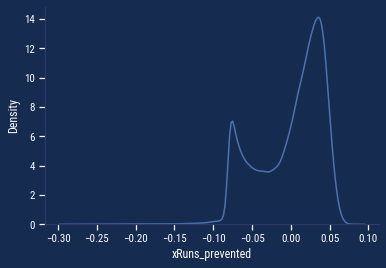

In [ ]:
sns.kdeplot(data=pitch_data, x='xRuns_prevented')
sns.despine()

In [ ]:
# "Best" appearances from previous day
pitch_data.loc[pitch_data['game_date']==pitch_data['game_date'].max()].groupby(['player_name','game_date'])['xRuns_prevented'].sum().sort_values(ascending=False).head(10)

player_name       game_date 
George Kirby      2022-06-27    0.689103
Kevin Gausman     2022-06-27    0.513743
Noah Syndergaard  2022-06-27    0.423466
Ian Gibaut        2022-06-27    0.421058
Keegan Akin       2022-06-27    0.416329
Jackson Kowar     2022-06-27    0.359099
Tyler Wells       2022-06-27    0.353731
Shaun Anderson    2022-06-27    0.312510
Adam Wainwright   2022-06-27    0.287088
Phil Bickford     2022-06-27    0.274971
Name: xRuns_prevented, dtype: float64

In [184]:
pitcher_lookup = 'Keegan Akin'

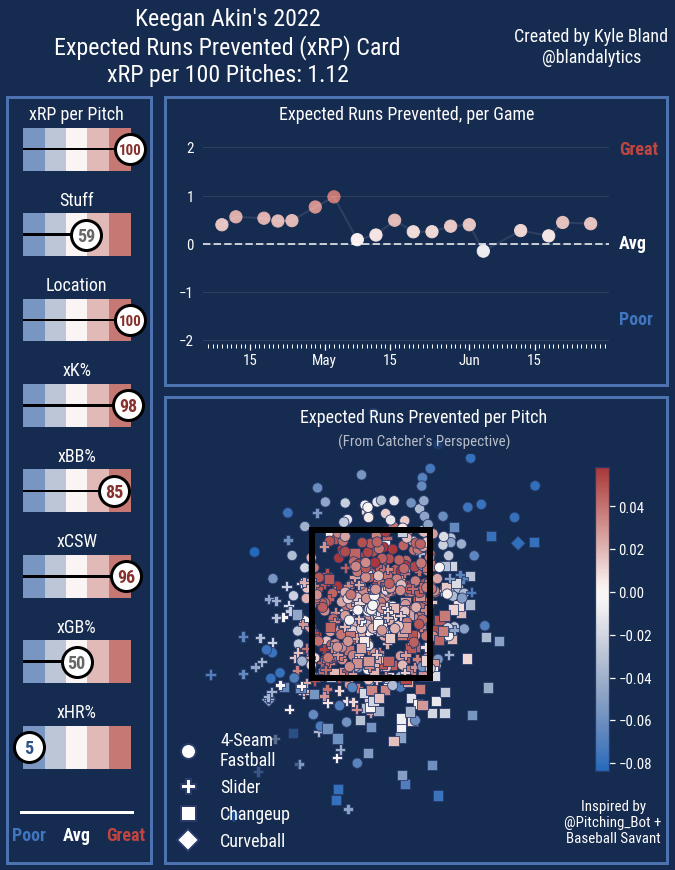

In [185]:
xRP_card(pitcher_lookup)

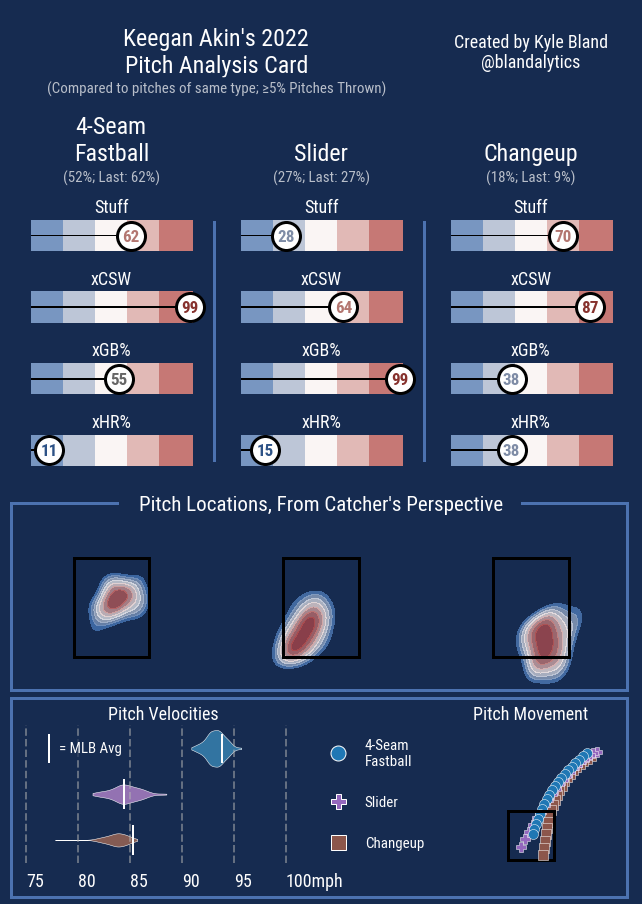

In [186]:
# Need to redefine these functions, if running after the batter cards
# Need to troubleshoot where the re-definition pops up from batters
def x(t,x0,vx0,ax):
  return x0 + vx0*t + (0.5*ax)*t**2

def y(t,z0,vz0,az):
  return z0 + vz0*t + (0.5*az)*t**2
xRP_pitch_card(pitcher_lookup)

In [214]:
pitcher = (
      pitch_data
      .loc[pitch_data['player_name']
           .str
           .contains(pitcher_lookup),
           'player_name']
      .unique()[0]
      )

In [215]:
pitch_data.loc[pitch_data['player_name']==pitcher].groupby('pitch_name')[['pitch_wOBA','command_wOBA','stuff_wOBA']].mean()

,pitch_wOBA,command_wOBA,stuff_wOBA
pitch_name,,,
4-Seam Fastball,-0.016518,-0.018608,-0.048885
Changeup,-0.003194,-0.004892,-0.068907
Curveball,0.038368,0.027982,-0.060448
Slider,-0.019619,-0.027841,-0.068729


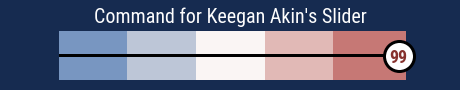

In [217]:
fig, ax = plt.subplots(figsize=(8,1))
test_pitch = 'Slider'
test_stat = 'command_percentile'
bullet_chart(pitch_bullet_data(pitch_data,pitch_count=100, pitch_type=test_pitch), pitcher, ax, test_stat, 1.5)
ax.set_title("{} for {}'s {}".format(test_stat[:test_stat.find('_')].title(),pitcher,test_pitch), fontsize=20)
sns.despine(left=True, bottom=True)

# Batter Outcomes

In [209]:
# Identical DF for batters
batter_data = pitch_data.copy()
batter_data['pitches'] = batter_data['pitch_name'].groupby(batter_data['batter_name']).transform('count')
# Pitches faced cutoff
batter_pitch_threshold = int(batter_data['pitches'].quantile(0.2))
print('Min pitches for batters: {}'.format(batter_pitch_threshold))

Min pitches for batters: 558


In [ ]:
# Map outcomes
batter_data['pitch_outcome'] = (
    batter_data
    .apply(lambda x: x['bb_bucket'] if x['cleaned_description']=='hit_into_play'
           else x['cleaned_description'] if x['cleaned_description'] in ['foul_strike', 'called_strike','swinging_strike'] 
           else x['events'] if x['events']=='hit_by_pitch' 
           else 'ball',
           axis=1)
)

## Batting Eye
Ability to judge the strikezone

In [ ]:
# Binary swing/take decision
batter_data['swing_dec'] = 'take'
batter_data.loc[batter_data['cleaned_description'].isin(['hit_into_play', 'foul_strike','swinging_strike']),'swing_dec'] = 'swing'

In [ ]:
# compare probabilities for called strike/hit-by-pitch/ball only
sz_judge_cols = ['ball_pred_p','hit_by_pitch_pred_p','called_strike_pred_p']

# Swings are called strike probability / total
# Takes are Ball + HBP probability / total 
batter_data['strike_zone_judgement'] = None
batter_data.loc[batter_data['swing_dec']=='take','strike_zone_judgement'] = batter_data[['ball_pred_p','hit_by_pitch_pred_p']].sum(axis=1).div(batter_data[sz_judge_cols].sum(axis=1))
batter_data.loc[batter_data['swing_dec']=='swing','strike_zone_judgement'] = batter_data['called_strike_pred_p'].div(batter_data[sz_judge_cols].sum(axis=1))

In [ ]:
print('Strike Zone Judgement')
batter_data.loc[batter_data['pitches']>batter_pitch_threshold].groupby('batter_name')['strike_zone_judgement'].mean().sort_values(ascending=False)#.head(15)

Strike Zone Judgement


batter_name
Brandon Belt        0.763911
Kyle Tucker         0.752937
Chris Taylor        0.750503
J.D. Davis          0.741889
George Springer     0.741191
                      ...   
Jesus Aguilar       0.626082
Raimel Tapia        0.625400
Jose Iglesias       0.624024
Daniel Vogelbach    0.614405
Javier Baez         0.596170
Name: strike_zone_judgement, Length: 271, dtype: float64

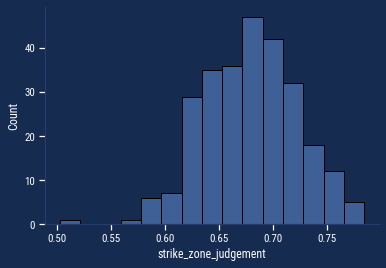

In [ ]:
sns.histplot(batter_data.loc[(batter_data['pitches']>batter_pitch_threshold) &
                (batter_data['swing_dec']=='swing')].groupby('batter_name')['strike_zone_judgement'].mean())
sns.despine()

## Contact
Actual contact  - expected contact

In [ ]:
# Did they make contact on a swing
batter_data['contact'] = None
batter_data.loc[batter_data['swing_dec']=='swing','contact'] = 0
batter_data.loc[(batter_data['swing_dec']=='swing') &
                batter_data['cleaned_description'].isin(['hit_into_play', 'foul_strike']),'contact'] = 1

In [ ]:
# (Contact outcome - contact probability)
batter_data['contact_ability'] = None
batter_data.loc[batter_data['swing_dec']=='swing','contact_ability'] = batter_data['contact'] - batter_data['contact_raw_p']
batter_data['season_contact_ability'] = batter_data['contact_ability'].groupby(batter_data['batter_name']).transform('mean')

In [ ]:
print('Best contact hitters (Contact % above expected)')
batter_data.loc[(batter_data['pitches']>batter_pitch_threshold) &
                (batter_data['swing_dec']=='swing')].groupby('batter_name')['season_contact_ability'].mean().sort_values(ascending=False).head(20)

Best contact hitters (Contact % above expected)


batter_name
Luis Arraez           0.155808
Steven Kwan           0.150128
Jose Iglesias         0.149690
Jose Ramirez          0.149046
Nico Hoerner          0.137789
Jean Segura           0.135531
Isiah Kiner-Falefa    0.130723
Keibert Ruiz          0.130714
Adam Frazier          0.128764
Wander Franco         0.124253
Jose Altuve           0.121858
Michael Brantley      0.121581
Alex Verdugo          0.120027
Miguel Rojas          0.118373
Yulieski Gurriel      0.116930
Austin Meadows        0.112248
Andrew Vaughn         0.109989
Kyle Farmer           0.106778
Alejandro Kirk        0.103606
Amed Rosario          0.102414
Name: season_contact_ability, dtype: float64

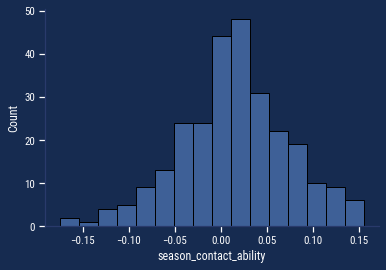

In [ ]:
sns.histplot(batter_data.loc[(batter_data['pitches']>batter_pitch_threshold) &
                (batter_data['swing_dec']=='swing')].groupby('batter_name')['season_contact_ability'].mean())
sns.despine()

## Swing Decisions
Value of Take/Swing

In [ ]:
# Value columsn for swing/take
take_cols = ['ball_pred_wOBA_p','hit_by_pitch_pred_wOBA_p','called_strike_pred_wOBA_p']
swing_cols = ['foul_strike_pred_wOBA_p', 'swinging_strike_pred_wOBA_p', '50+deg_pred_wOBA_p',
              '10deg: <90mph_pred_wOBA_p', '10deg: 90-95mph_pred_wOBA_p', '10deg: 95-100mph_pred_wOBA_p', '10deg: 100-105mph_pred_wOBA_p', '10deg: 105+mph_pred_wOBA_p',
              '10-20deg: <90mph_pred_wOBA_p', '10-20deg: 90-95mph_pred_wOBA_p', '10-20deg: 95-100mph_pred_wOBA_p', '10-20deg: 100-105mph_pred_wOBA_p', '10-20deg: 105+mph_pred_wOBA_p',
              '20-30deg: <90mph_pred_wOBA_p', '20-30deg: 90-95mph_pred_wOBA_p', '20-30deg: 95-100mph_pred_wOBA_p', '20-30deg: 100-105mph_pred_wOBA_p', '20-30deg: 105+mph_pred_wOBA_p',
              '30-40deg: <90mph_pred_wOBA_p', '30-40deg: 90-95mph_pred_wOBA_p', '30-40deg: 95-100mph_pred_wOBA_p', '30-40deg: 100-105mph_pred_wOBA_p', '30-40deg: 105+mph_pred_wOBA_p',
              '40-50deg: <90mph_pred_wOBA_p', '40-50deg: 90-95mph_pred_wOBA_p', '40-50deg: 95-100mph_pred_wOBA_p', '40-50deg: 100-105mph_pred_wOBA_p', '40-50deg: 105+mph_pred_wOBA_p']

batter_data['decision_value'] = None
batter_data['take_value'] = batter_data[take_cols].sum(axis=1)
batter_data['swing_value'] = batter_data[swing_cols].sum(axis=1)
# Decision Value is opportunity cost of decision
# Takes are (take value - swing value)
batter_data.loc[batter_data['swing_dec']=='take','decision_value'] = batter_data['take_value'].sub(batter_data['swing_value'])
# Swings are (swing value - take value)
batter_data.loc[batter_data['swing_dec']=='swing','decision_value'] = batter_data['swing_value'].sub(batter_data['take_value'])

In [ ]:
print('Swing Decision Value (Estimated wOBA of takes/swings)')
batter_data.loc[batter_data['pitches']>batter_pitch_threshold].groupby('batter_name')['decision_value'].mean().sort_values(ascending=False).head(15)

Swing Decision Value (Estimated wOBA of takes/swings)


batter_name
Juan Soto           0.034302
Alex Bregman        0.032287
Anthony Rendon      0.030819
Max Muncy           0.030212
Mike Trout          0.029856
Will Smith          0.029704
Yandy Diaz          0.029286
Brandon Belt        0.029171
Taylor Ward         0.028452
Ji-Man Choi         0.028449
Max Stassi          0.028233
Mookie Betts        0.027917
Mike Yastrzemski    0.027343
Christian Walker    0.027262
Carlos Santana      0.027210
Name: decision_value, dtype: float64

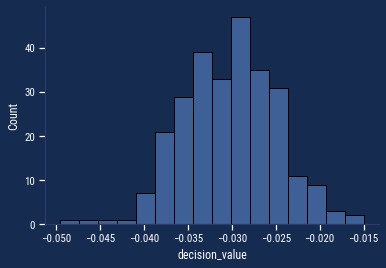

In [ ]:
sns.histplot(batter_data.loc[(batter_data['pitches']>batter_pitch_threshold) &
                (batter_data['swing_dec']=='swing')].groupby('batter_name')['decision_value'].mean())
sns.despine()

## Adjusted Power
wOBA from angle+velo bucket - exp wOBA for launch angle

In [ ]:
batter_data['avg_xISO_angle'] = -10 # Value will turn to None later

# Average xISO for each launch angle
batter_data.loc[~batter_data['xwOBA'].isna(),'avg_xISO_angle'] = batter_data.loc[~batter_data['xwOBA'].isna()].groupby('launch_angle')['xISO'].transform(lambda x: x.mean())

In [ ]:
# Adjusted Power is the value brought over the average "xISO" for that launch angle
# Idea is the extra launch speed at each angle is a proxy for their power
batter_data['adj_power'] = None
batter_data['adj_power'] = batter_data['xwOBA'].sub(batter_data['avg_xISO_angle'], fill_value=0)
batter_data['adj_power'] = batter_data['adj_power'].replace({10:None})

In [ ]:
print("Power hitters (non-single xwOBA, for BBE's Launch Angle)")
batter_data.loc[batter_data['pitches']>batter_pitch_threshold].groupby('batter_name')['adj_power'].mean().sort_values(ascending=False).tail(15)

Power hitters (non-single xwOBA, for BBE's Launch Angle)


batter_name
Jose Iglesias      0.219396
Lorenzo Cain       0.215319
Victor Robles      0.215150
Tucker Barnhart    0.214887
Nicky Lopez        0.213986
Marcus Semien      0.211619
Jed Lowrie         0.210537
Steven Kwan        0.208289
Kolten Wong        0.201225
Omar Narvaez       0.195904
Bryson Stott       0.192466
Austin Hedges      0.189011
Tyler Wade         0.186823
Myles Straw        0.173676
Tony Kemp          0.167029
Name: adj_power, dtype: float64

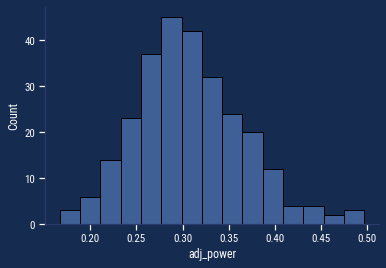

In [ ]:
sns.histplot(batter_data.loc[batter_data['pitches']>batter_pitch_threshold].groupby('batter_name')['adj_power'].mean())
sns.despine()

## Value on Contact 
Basically xwOBAcon, after adjusting for the quality of the pitch

In [ ]:
batter_data['value_on_contact'] = None
batter_data.loc[batter_data['contact']==1,'value_on_contact'] = batter_data['xwOBA'].sub(batter_data['pitch_wOBA'])

In [ ]:
print('Most valuable contact (increase over pitch wOBA)')
batter_data.loc[batter_data['pitches']>batter_pitch_threshold].groupby('batter_name')['value_on_contact'].mean().sort_values(ascending=False).head(15)

Most valuable contact (increase over pitch wOBA)


batter_name
Aaron Judge          0.625634
Mike Trout           0.612924
Yordan Alvarez       0.611016
Giancarlo Stanton    0.599810
Kyle Schwarber       0.590984
Ryan Mountcastle     0.556804
Bryce Harper         0.554882
Austin Riley         0.542598
J.D. Davis           0.538012
Shohei Ohtani        0.537351
Joc Pederson         0.536462
Dansby Swanson       0.530417
J.D. Martinez        0.529842
Joey Gallo           0.529641
Ronald Acuna         0.527015
Name: value_on_contact, dtype: float64

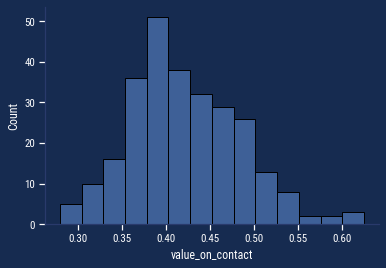

In [ ]:
sns.histplot(batter_data.loc[batter_data['pitches']>batter_pitch_threshold].groupby('batter_name')['value_on_contact'].mean())
sns.despine()

## Overall Hitting Ability
Outcome wOBA - pitch wOBA

In [ ]:
# Batter wOBA is the outcome value for every pitch seen (xwOBA for batted balls), above average
batter_data['batter_wOBA'] = batter_data['pitch_outcome'].map(woba_values) - batter_data['pitch_wOBA']
batter_data['adj_batter_wOBA'] = batter_data['batter_wOBA'] - batter_data['batter_wOBA'].min()
batter_data['xRuns_added'] = batter_data['batter_wOBA'].div(1.289)
batter_data['swing_runs_added'] = batter_data['decision_value'].div(1.289)
batter_data.loc[batter_data['pitches']>batter_pitch_threshold].groupby('batter_name')['batter_wOBA'].mean().sort_values(ascending=False).head(15)

batter_name
Yordan Alvarez       0.037649
Alejandro Kirk       0.022989
Aaron Judge          0.022753
Christian Walker     0.020698
Giancarlo Stanton    0.019422
Bryce Harper         0.018445
Taylor Ward          0.017113
Mike Trout           0.016957
Joc Pederson         0.016638
Kyle Schwarber       0.016508
Juan Soto            0.015650
Will Smith           0.015623
Shohei Ohtani        0.015178
Michael Brantley     0.014270
Freddie Freeman      0.013365
Name: batter_wOBA, dtype: float64

In [ ]:
batter_data.loc[(batter_data['pitches']<=batter_pitch_threshold) &
                (batter_data['pitches']>200)].groupby('batter_name')['batter_wOBA'].mean().sort_values(ascending=False).head(15)

batter_name
Kyle Garlick         0.021112
William Contreras    0.018357
Matt Carpenter       0.013712
Danny Jansen         0.011570
Victor Caratini      0.011320
Edward Olivares      0.008896
Miguel Sano          0.007640
Orlando Arcia        0.007341
Matt Vierling        0.006929
Evan Longoria        0.006680
Nick Solak           0.005237
Nolan Gorman         0.004760
Adley Rutschman      0.004745
Roberto Perez        0.004734
Ryan O'Hearn         0.004520
Name: batter_wOBA, dtype: float64

In [ ]:
hitter_val_cols = ['batter_wOBA','strike_zone_judgement','contact_ability','decision_value','value_on_contact','adj_power']
hitter_val = batter_data.loc[batter_data['pitches']>batter_pitch_threshold].groupby('batter_name', as_index=False)[hitter_val_cols+['pitches']].agg({
    'batter_wOBA':'mean',
    'decision_value':'mean',
    'contact_ability':'mean',
    'value_on_contact':'mean',
    'strike_zone_judgement':'mean',
    'adj_power':'mean',
    'pitches':'mean'
}).sort_values('batter_wOBA', ascending=False).reset_index(drop=True)

hitter_val['pitches'] = hitter_val['pitches'].astype('int')

for col in hitter_val_cols:
  hitter_val[col] = hitter_val[col].rank(pct=True).round(2).mul(100).astype('int')

hitter_val[['batter_name','pitches']+hitter_val_cols].head(30)

,batter_name,pitches,batter_wOBA,strike_zone_judgement,contact_ability,decision_value,value_on_contact,adj_power
0,Yordan Alvarez,1057,100,77,57,87,99,99
1,Alejandro Kirk,941,100,62,93,92,82,83
2,Aaron Judge,1295,99,38,24,72,100,100
3,Christian Walker,1081,99,89,42,95,88,83
4,Giancarlo Stanton,1009,99,30,8,66,99,100
5,Bryce Harper,1034,98,74,43,8,98,97
6,Taylor Ward,903,98,64,48,97,94,89
7,Mike Trout,1167,97,91,11,99,100,99
8,Joc Pederson,804,97,68,56,61,96,96
9,Kyle Schwarber,1376,97,39,18,94,99,99


In [ ]:
# Who has the biggest difference between how well they see the ball and how well they hit the ball
see_ball_hit_ball_disconnect = hitter_val[['contact_ability','adj_power']].mean(axis=1).sub(hitter_val[['strike_zone_judgement','decision_value']].mean(axis=1)).sort_values().reset_index().rename(columns={0:'Diff'})
hitter_val.iloc[list(see_ball_hit_ball_disconnect.loc[[0,1,see_ball_hit_ball_disconnect.shape[0]-2,see_ball_hit_ball_disconnect.shape[0]-1]]['index'])]

,batter_name,batter_wOBA,decision_value,contact_ability,value_on_contact,strike_zone_judgement,adj_power,pitches
254,Jed Lowrie,6,82,23,3,93,3,653
239,Brandon Crawford,12,65,4,18,94,20,901
158,Harold Castro,42,7,89,78,23,78,611
54,Rowdy Tellez,80,24,80,86,4,87,1093


In [ ]:
# Multi-Player Lookup
(hitter_val
 .loc[hitter_val['batter_name']
      .isin(['Ryan Mountcastle','Rhys Hoskins','Max Muncy','Rowdy Tellez','Christian Walker','Andrew Vaughn','Garrett Cooper',
             'Ji-Man Choi']),
      ['batter_name','pitches']+hitter_val_cols]
 )

,batter_name,pitches,batter_wOBA,strike_zone_judgement,contact_ability,decision_value,value_on_contact,adj_power
3,Christian Walker,1081,99,89,42,95,88,83
23,Ji-Man Choi,870,92,85,13,97,94,92
30,Garrett Cooper,1033,89,14,69,52,87,90
41,Ryan Mountcastle,1022,85,47,41,6,98,97
54,Rowdy Tellez,1093,80,4,80,24,86,87
66,Rhys Hoskins,1346,76,42,57,82,76,73
72,Max Muncy,977,73,44,25,99,41,28
73,Andrew Vaughn,921,73,4,94,31,60,67


## Strike Zone Prep
Breaking the strike zone into various zones

In [ ]:
y_bot_bat = 0.5
y_lim_bat = 4.5
x_scale_bat = 11/6
hitter_val_cols = ['batter_wOBA','strike_zone_judgement','contact_ability','decision_value','value_on_contact','adj_power']
scale_val_bat=2

In [ ]:
# 10x10 grid of all pitches
batter_data['h_zone'] = 0
batter_data.loc[(batter_data['h_loc']<-5/24) &
                (batter_data['h_loc']>=-5/12),'h_zone'] = -1
batter_data.loc[(batter_data['h_loc']<-5/12) &
                (batter_data['h_loc']>=-15/24),'h_zone'] = -2
batter_data.loc[(batter_data['h_loc']<-15/24) &
                (batter_data['h_loc']>=-10/12),'h_zone'] = -3
batter_data.loc[(batter_data['h_loc']<-10/12),'h_zone'] = -4

batter_data.loc[(batter_data['h_loc']<5/24) &
                (batter_data['h_loc']>=0),'h_zone'] = 1
batter_data.loc[(batter_data['h_loc']>5/24) &
                (batter_data['h_loc']<=5/12),'h_zone'] = 2
batter_data.loc[(batter_data['h_loc']>5/12) &
                (batter_data['h_loc']<=15/24),'h_zone'] = 3
batter_data.loc[(batter_data['h_loc']>15/24) &
                (batter_data['h_loc']<=10/12),'h_zone'] = 4
batter_data.loc[(batter_data['h_loc']>10/12),'h_zone'] = 5

batter_data['v_zone'] = 0
batter_data.loc[(batter_data['v_loc']<=(batter_data['sz_top']-batter_data['sz_bot'])/3+batter_data['sz_bot']) &
                (batter_data['v_loc']>(batter_data['sz_top']-batter_data['sz_bot'])/6+batter_data['sz_bot']),'v_zone'] = -1
batter_data.loc[(batter_data['v_loc']<=(batter_data['sz_top']-batter_data['sz_bot'])/6+batter_data['sz_bot']) &
                (batter_data['v_loc']>batter_data['sz_bot']),'v_zone'] = -2
batter_data.loc[(batter_data['v_loc']<=batter_data['sz_bot']) &
                (batter_data['v_loc']>batter_data['sz_bot']-(batter_data['sz_top']-batter_data['sz_bot'])/6),'v_zone'] = -3
batter_data.loc[(batter_data['v_loc']<=batter_data['sz_bot']-(batter_data['sz_top']-batter_data['sz_bot'])/6),'v_zone'] = -4

batter_data.loc[(batter_data['v_loc']>batter_data['sz_top']-(batter_data['sz_top']-batter_data['sz_bot'])/2) &
                (batter_data['v_loc']<=batter_data['sz_top']-(batter_data['sz_top']-batter_data['sz_bot'])/3),'v_zone'] = 1
batter_data.loc[(batter_data['v_loc']>batter_data['sz_top']-(batter_data['sz_top']-batter_data['sz_bot'])/3) &
                (batter_data['v_loc']<=batter_data['sz_top']-(batter_data['sz_top']-batter_data['sz_bot'])/6),'v_zone'] = 2
batter_data.loc[(batter_data['v_loc']>batter_data['sz_top']-(batter_data['sz_top']-batter_data['sz_bot'])/6) &
                (batter_data['v_loc']<=batter_data['sz_top']),'v_zone'] = 3
batter_data.loc[(batter_data['v_loc']>batter_data['sz_top']) &
                (batter_data['v_loc']<=batter_data['sz_top']+(batter_data['sz_top']-batter_data['sz_bot'])/6),'v_zone'] = 4
batter_data.loc[(batter_data['v_loc']>batter_data['sz_top']+(batter_data['sz_top']-batter_data['sz_bot'])/6),'v_zone'] = 5

In [ ]:
# Format grid to fit zone groups
batter_data['h_group'] = 0
batter_data.loc[batter_data['h_zone'].isin([-2,-1]),'h_group'] = -1
batter_data.loc[(batter_data['h_zone']<-2) |
                ((batter_data['h_zone']<1) & batter_data['v_zone'].isin([-4,-3,4,5])),'h_group'] = -2
batter_data.loc[batter_data['h_zone'].isin([2,3]),'h_group'] = 1
batter_data.loc[(batter_data['h_zone']>3) |
                ((batter_data['h_zone']>=1) & batter_data['v_zone'].isin([-4,-3,4,5])),'h_group'] = 2

batter_data['v_group'] = 0
batter_data.loc[batter_data['v_zone'].isin([-2,-1]),'v_group'] = -1
batter_data.loc[(batter_data['v_zone']<-2) |
                ((batter_data['v_zone']<1) & batter_data['h_zone'].isin([-4,-3,4,5])),'v_group'] = -2
batter_data.loc[batter_data['v_zone'].isin([2,3]),'v_group'] = 1
batter_data.loc[(batter_data['v_zone']>3) |
                ((batter_data['v_zone']>=1) & batter_data['h_zone'].isin([-4,-3,4,5])),'v_group'] = 2

In [ ]:
# Create a DF that contains all possible horizontal/vertical zone combinations
zone_df = pd.DataFrame()

zone_start = -4
zone_cutoff = 5

for x in range(zone_start,zone_cutoff+1):
  for y in range(zone_start,zone_cutoff+1):
    zone_df = zone_df.append({'h_zone':int(x),'v_zone':int(y)}, ignore_index=True)

zone_df = zone_df.reset_index()

# Combine horizontal/vertical to Statcast Zone classifications (9 in-zone groups, 4 out-of-zone)
zone_df['zone'] = None
zone_df.loc[zone_df['index'].isin(list(range(22,24))+list(range(32,34))),'zone'] = 1
zone_df.loc[zone_df['index'].isin(list(range(42,44))+list(range(52,54))),'zone'] = 2
zone_df.loc[zone_df['index'].isin(list(range(62,64))+list(range(72,74))),'zone'] = 3
zone_df.loc[zone_df['index'].isin(list(range(24,26))+list(range(34,36))),'zone'] = 4
zone_df.loc[zone_df['index'].isin(list(range(44,46))+list(range(54,56))),'zone'] = 5
zone_df.loc[zone_df['index'].isin(list(range(64,66))+list(range(74,76))),'zone'] = 6
zone_df.loc[zone_df['index'].isin(list(range(26,28))+list(range(36,38))),'zone'] = 7
zone_df.loc[zone_df['index'].isin(list(range(46,48))+list(range(56,58))),'zone'] = 8
zone_df.loc[zone_df['index'].isin(list(range(66,68))+list(range(76,78))),'zone'] = 9

zone_df.loc[zone_df['index'].isin(list(range(0,5))+list(range(10,15))+list(range(20,22))+list(range(30,32))+list(range(40,42))),'zone'] = 11
zone_df.loc[zone_df['index'].isin(list(range(50,52))+list(range(60,62))+list(range(70,72))+list(range(80,85))+list(range(90,95))),'zone'] = 12
zone_df.loc[zone_df['index'].isin(list(range(5,10))+list(range(15,20))+list(range(28,30))+list(range(38,40))+list(range(48,50))),'zone'] = 13
zone_df.loc[zone_df['index'].isin(list(range(58,60))+list(range(68,70))+list(range(78,80))+list(range(85,90))+list(range(95,100))),'zone'] = 14

zone_df = zone_df.drop(columns=['index'])
batter_data = batter_data.merge(zone_df,how='inner',on=['h_zone','v_zone'])

## Batter Viz Functions

In [ ]:
def bullet_chart_bat(df,player_name,ax, stat, scale_val,buckets=bullet_limits):
  plot_val = int(df.loc[df['batter_name']==player_name,stat].mean()*100)
  ax.set_yticks([1])

  prev_limit = 0
  for idx, lim in enumerate(bullet_limits):
      ax.barh([1], lim-prev_limit, left=prev_limit, height=30, color=palette[idx])
      prev_limit = lim

  ax.barh([1], plot_val, color='black', height=1.2*scale_val)
  ax.plot(plot_val, [1], marker='o', linestyle='', color=pl_white, ms=round(20*scale_val), alpha=1, mec='black', mew=round(2*scale_val), linewidth=round(scale_val))
  ax.set(xlim=(-15,115))
  ax.text(x=plot_val, y=0, s=plot_val, ha='center', va='center', fontsize=round(12*scale_val if plot_val < 100 else 10*scale_val), fontweight='bold',
          color=bullet_text_palette[int(min(99,plot_val)/20)])
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.tick_params(left=False, bottom=False)

In [ ]:
def pitch_bullet_bat(df, pitch_type='4-Seam Fastball'):
  bullet_df = (
      df
      .loc[df['pitch_name'].isin(pitch_type)][hitter_val_cols+['batter_name','pitches']]
      .copy()
  )
  
  bullet_df = bullet_df.groupby('batter_name',as_index=False)[hitter_val_cols+['pitches']].agg({
      'batter_wOBA':'mean',
      'decision_value':'mean',
      'contact_ability':'mean',
      'strike_zone_judgement':'mean',
      'adj_power':'mean',
      'pitches':'mean',
      'value_on_contact':'mean'
  })

  bullet_df['xRA_percentile'] = bullet_df['batter_wOBA'].rank(pct=True).round(2)
  bullet_df['correct_percentile'] = bullet_df['strike_zone_judgement'].rank(pct=True).round(2)
  bullet_df['value_percentile'] = bullet_df['decision_value'].rank(pct=True).round(2)
  bullet_df['added_wOBA_percentile'] = bullet_df['value_on_contact'].rank(pct=True).round(2)
  bullet_df['contact_percentile'] = bullet_df['contact_ability'].rank(pct=True).round(2)
  bullet_df['power_percentile'] = bullet_df['adj_power'].rank(pct=True).round(2)

  return bullet_df

In [ ]:
# Load stadium dimensions
stadium_df = pd.read_csv('https://raw.githubusercontent.com/jldbc/pybaseball/master/pybaseball/data/mlbstadiums.csv').drop(columns=['Unnamed: 0'])

# Function to plot stadium dimensions
def stadium_plot(team, ax, scale_val_bat):
  stadium_graph_data = stadium_df.loc[stadium_df['team']==team]

  for segment in ['outfield_outer','foul_lines','infield_inner','infield_outer']:
    ax.plot(stadium_graph_data.loc[stadium_df['segment']==segment,'x'],
              stadium_graph_data.loc[stadium_df['segment']==segment,'y'], 
              linewidth=round(scale_val_bat), color='black', alpha=0.7)

In [ ]:
# Heatmap of where a batter gains/loses value for each pitch type seen
def wOBA_heatmap(player_name_lookup, ax, pitch=''):
  batter_name = (
      batter_data
      .loc[~batter_data['batter_name'].isna() &
           batter_data['batter_name']
           .str
           .contains(player_name_lookup),
           'batter_name']
      .unique()[0]
      )
  
  heatmap_data = batter_data.loc[batter_data['pitch_name'].isin(pitch)] if pitch!='' else batter_data
  
  colorscale_df = (
      batter_data.loc[batter_data['zone'].isin(range(1,10))]
      .groupby(['batter_name','zone'])['xRuns_added'].mean()
  )

  vmin = -colorscale_df.quantile(0.9)
  vcenter = 0
  vmax = colorscale_df.quantile(0.9)
  
  # Apply batter's values to completed zone map
  heatmap_df = (
      heatmap_data.loc[heatmap_data['batter_name']==batter_name] # Filter batter
      .groupby('zone', as_index=False)['xRuns_added'].mean() # Find mean of each zone
      .merge(zone_df,how='right',on='zone') # Apply to filled zone map
      )

  heatmap = sns.heatmap(heatmap_df.pivot('v_zone', 'h_zone', 'xRuns_added'),
              vmin=vmin, 
              center=vcenter,
              vmax=vmax,
              cbar=False,
              cmap='vlag')
  blank_color = '#333333'
  heatmap.set_facecolor(blank_color)

  # Within SZ Grid
  ax.axhline(4, xmin=0.2, xmax=0.8, color=blank_color, linewidth=2)
  ax.axhline(6, xmin=0.2, xmax=0.8, color=blank_color, linewidth=2)
  ax.axvline(4, ymin=0.2, ymax=0.8, color=blank_color, linewidth=2)
  ax.axvline(6, ymin=0.2, ymax=0.8, color=blank_color, linewidth=2)

  # Out of SZ Grid
  ax.axhline(5, xmin=0.8, xmax=1, color=blank_color, linewidth=2)
  ax.axhline(5, xmin=0, xmax=0.2, color=blank_color, linewidth=2)
  ax.axvline(5, ymin=0.8, ymax=1, color=blank_color, linewidth=2)
  ax.axvline(5, ymin=0, ymax=0.2, color=blank_color, linewidth=2)

  # Strikezone
  ax.axhline(2, xmin=0.2, xmax=0.8, color='black', linewidth=2*2)
  ax.axhline(8, xmin=0.2, xmax=0.8, color='black', linewidth=2*2)
  ax.axvline(2, ymin=0.2, ymax=0.8, color='black', linewidth=2*2)
  ax.axvline(8, ymin=0.2, ymax=0.8, color='black', linewidth=2*2)

  ax.set(xlabel=None, ylabel=None)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.tick_params(left=False, bottom=False)

  sns.despine(left=False, bottom=False)

In [ ]:
def xRA_card(player_name_lookup,pitch_threshold=batter_pitch_threshold,scale_val_bat=2):
  batter_name = (
      batter_data
      .loc[~batter_data['batter_name'].isna() &
           batter_data['batter_name']
           .str
           .contains(player_name_lookup),
           'batter_name']
      .unique()[0]
      )
  
  graph_data = batter_data.loc[batter_data['batter_name']==batter_name].copy()
  # Plot a generic stadium outline if player has played for multiple teams
  team = 'generic' if len(graph_data['bat_team'].unique())>1 else graph_data['bat_team'].unique()[0]

  sz_top = graph_data['sz_top'].median()
  sz_bot = graph_data['sz_bot'].median()
  y_lim_bat = sz_top+1
  y_bot_bat = sz_bot-1

  pitch_threshold = min(pitch_threshold,graph_data.shape[0])

  # Generate data for bullet charts
  bullet_df = batter_data.loc[batter_data['pitches']>=pitch_threshold].groupby('batter_name', as_index=False)[hitter_val_cols+['pitches']].agg({
      'batter_wOBA':'mean',
      'decision_value':'mean',
      'contact_ability':'mean',
      'value_on_contact':'mean',
      'strike_zone_judgement':'mean',
      'adj_power':'mean',
      'pitches':'mean'
  })

  # Split df of pitches seen out by pitcher handedness
  vs_R_df = batter_data.loc[(batter_data['pitches']>=pitch_threshold) &
                            (batter_data['p_hand']=='R')].groupby('batter_name', as_index=False)[['contact_ability','adj_power','pitches']].agg({
      'contact_ability':'mean',
      'adj_power':'mean',
      'pitches':'mean'
  })
  vs_R_pitches = batter_data.loc[(batter_data['batter_name']==batter_name) &
                                 (batter_data['p_hand']=='R')].shape[0]

  vs_L_df = batter_data.loc[(batter_data['pitches']>=pitch_threshold) &
                            (batter_data['p_hand']=='L')].groupby('batter_name', as_index=False)[['contact_ability','adj_power','pitches']].agg({
      'contact_ability':'mean',
      'adj_power':'mean',
      'pitches':'mean'
  })
  vs_L_pitches = batter_data.loc[(batter_data['batter_name']==batter_name) &
                                 (batter_data['p_hand']=='L')].shape[0]
  
  bullet_df['xRA_percentile'] = bullet_df['batter_wOBA'].rank(pct=True).round(2)
  bullet_df['correct_percentile'] = bullet_df['strike_zone_judgement'].rank(pct=True).round(2)
  bullet_df['value_percentile'] = bullet_df['decision_value'].rank(pct=True).round(2)
  bullet_df['added_wOBA_percentile'] = bullet_df['value_on_contact'].rank(pct=True).round(2)

  # Contact and Power broken out by pitcher handedness (see platoon splits)
  vs_R_df['contact_percentile'] = vs_R_df['contact_ability'].rank(pct=True).round(2)
  vs_R_df['power_percentile'] = vs_R_df['adj_power'].rank(pct=True).round(2)

  vs_L_df['contact_percentile'] = vs_L_df['contact_ability'].rank(pct=True).round(2)
  vs_L_df['power_percentile'] = vs_L_df['adj_power'].rank(pct=True).round(2)

  fig = plt.figure(figsize=(6*scale_val_bat,8*scale_val_bat))

  grid = plt.GridSpec(10, 15, wspace=0.05*scale_val_bat, hspace=0.4*scale_val_bat,
                      width_ratios=[0.2,0.1]+[3/4]*4+[0.2,0.1,0.2]+[3/4]*4+[0.2, 0.2],
                      height_ratios=[2,0.65,0.5,0.65,3.5,0.2,0.2,0.65,0.65,0])
  
  title_ax = plt.subplot(grid[0, :-4])
  title_ax.text(0,-0.25,"{}'s 2022\nExpected Runs Added (xRA) Card\nxRA per Game: {}".format(batter_name,round(graph_data['xRuns_added'].mean() * (graph_data.shape[0] / len(graph_data['game_pk'].unique())),2)), ha='center', va='center', fontsize=round(14*scale_val_bat),
           bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  title_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1.5,1))
  title_ax.set_xticklabels([])
  title_ax.set_yticklabels([])
  title_ax.tick_params(left=False, bottom=False)

  owner_ax = plt.subplot(grid[0, -4:])
  owner_ax.text(0,0,'Created by Kyle Bland\n@blandalytics', ha='center', va='center',fontweight='normal', fontsize=round(8*scale_val_bat),
            bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  owner_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  owner_ax.set_xticklabels([])
  owner_ax.set_yticklabels([])
  owner_ax.tick_params(left=False, bottom=False)

  xRA_bullet_ax = plt.subplot(grid[1, 3:12])
  xRA_bullet_ax.set_xticklabels([])
  xRA_bullet_ax.set_yticklabels([])
  xRA_bullet_ax.tick_params(left=False, bottom=False)
  xRA_bullet_ax.set_title('xRA per Pitch', fontsize=int(10*scale_val_bat))
  bullet_chart_bat(bullet_df, batter_name, xRA_bullet_ax,'xRA_percentile',1.5)
  
  # Label the "Poor" side of xRA bullet
  scale_ax_1 = plt.subplot(grid[1, :3])
  scale_ax_1.text(0.9,0.5,'Poor', ha='center', va='center', fontweight='bold', fontsize=int(12*scale_val_bat), color='#4075bf')
  scale_ax_1.set(xlabel=None, ylabel=None)
  scale_ax_1.set_xticklabels([])
  scale_ax_1.set_yticklabels([])
  scale_ax_1.tick_params(left=False, bottom=False)
  
  # Label the "Great" side of xRA bullet
  scale_ax_2 = plt.subplot(grid[1, 12:])
  scale_ax_2.text(0.1,0.5,'Great', ha='center', va='center', fontweight='bold', fontsize=int(12*scale_val_bat), color='#bf4640')
  scale_ax_2.set(xlabel=None, ylabel=None)
  scale_ax_2.set_xticklabels([])
  scale_ax_2.set_yticklabels([])
  scale_ax_2.tick_params(left=False, bottom=False)

  plot_title_ax = plt.subplot(grid[2, :])
  plot_title_ax.text(0,1,'Swing Decisions', ha='center', va='center', fontsize=round(12*scale_val_bat),
                     bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  plot_title_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  plot_title_ax.set_xticklabels([])
  plot_title_ax.set_yticklabels([])
  plot_title_ax.tick_params(left=False, bottom=False)

  # Strikezone "correctness"
  correct_bullet_ax = plt.subplot(grid[3, 2:6])
  correct_bullet_ax.set_xticklabels([])
  correct_bullet_ax.set_yticklabels([])
  correct_bullet_ax.tick_params(left=False, bottom=False)
  correct_bullet_ax.set_title('Ball/Strike Judgement', fontsize=int(10*scale_val_bat))
  bullet_chart_bat(bullet_df, batter_name, correct_bullet_ax,'correct_percentile',1.5)

  # Decison value
  value_bullet_ax = plt.subplot(grid[3, 9:13])
  value_bullet_ax.set_xticklabels([])
  value_bullet_ax.set_yticklabels([])
  value_bullet_ax.tick_params(left=False, bottom=False)
  value_bullet_ax.set_title('Decision Value', fontsize=int(10*scale_val_bat))
  bullet_chart_bat(bullet_df, batter_name, value_bullet_ax,'value_percentile',1.5)

  colorbar_scale = 0.9

  swing_norm = colors.TwoSlopeNorm(vmin=-0.02,
                                   vcenter=0.5,
                                   vmax=1.02)

  swing_correct_ax = plt.subplot(grid[4, 2:6])
  sns.scatterplot(data=graph_data, 
                    x='h_loc', 
                    y='v_loc', 
                    s=round(35*scale_val_bat), 
                    hue='strike_zone_judgement',
                    hue_norm=swing_norm,
                    palette='RdYlGn',
                    edgecolor='#293a6b',
                    alpha=0.8,
  #                  linewidth=0.5,
                    ax=swing_correct_ax,
                    legend=False
                    )

  swing_correct_ax.axhline(sz_bot, xmin=(12*x_scale_bat-10)/(24*x_scale_bat), xmax=(12*x_scale_bat+10)/(24*x_scale_bat), color='black', linewidth=2*scale_val_bat)
  swing_correct_ax.axvline(10/12, ymin=(sz_bot-y_bot_bat)/(y_lim_bat-y_bot_bat), ymax=(sz_top-y_bot_bat)/(y_lim_bat-y_bot_bat), color='black', linewidth=2*scale_val_bat)
  swing_correct_ax.axvline(-10/12, ymin=(sz_bot-y_bot_bat)/(y_lim_bat-y_bot_bat), ymax=(sz_top-y_bot_bat)/(y_lim_bat-y_bot_bat), color='black', linewidth=2*scale_val_bat)
  swing_correct_ax.axhline(sz_top, xmin=(12*x_scale_bat-10)/(24*x_scale_bat), xmax=(12*x_scale_bat+10)/(24*x_scale_bat), color='black', linewidth=2*scale_val_bat)

  sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=swing_norm)
  sm.set_array([])
  cb = fig.colorbar(sm, ax=[swing_correct_ax], location='left', shrink=colorbar_scale, aspect=19*colorbar_scale, pad=0.05)
  cb.ax.tick_params(labelsize=round(8*scale_val_bat))
  cb.ax.set_ylabel('Correctness',fontsize=round(8*scale_val_bat))

  swing_correct_ax.set(xlabel=None, xlim=(-x_scale_bat,x_scale_bat), ylabel=None, ylim=(y_bot_bat,y_lim_bat))
  swing_correct_ax.set_xticklabels([])
  swing_correct_ax.set_yticklabels([])
  swing_correct_ax.tick_params(left=False, bottom=False)

  decision_norm = colors.TwoSlopeNorm(vmin=-batter_data['swing_runs_added'].quantile(0.9), 
                                      vcenter=0,
                                      vmax=batter_data['swing_runs_added'].quantile(0.9))

  swing_value_ax = plt.subplot(grid[4, 9:13])
  sns.scatterplot(data=graph_data, 
                    x='h_loc', 
                    y='v_loc', 
                    s=round(35*scale_val_bat), 
                    hue='swing_runs_added',
                    palette='vlag',
                    hue_norm=decision_norm,
                    edgecolor='#293a6b',
                    alpha=0.9,
                    ax=swing_value_ax,
                    legend=False
                    )

  swing_value_ax.axhline(sz_bot, xmin=(12*x_scale_bat-10)/(24*x_scale_bat), xmax=(12*x_scale_bat+10)/(24*x_scale_bat), color='black', linewidth=2*scale_val_bat)
  swing_value_ax.axvline(10/12, ymin=(sz_bot-y_bot_bat)/(y_lim_bat-y_bot_bat), ymax=(sz_top-y_bot_bat)/(y_lim_bat-y_bot_bat), color='black', linewidth=2*scale_val_bat)
  swing_value_ax.axvline(-10/12, ymin=(sz_bot-y_bot_bat)/(y_lim_bat-y_bot_bat), ymax=(sz_top-y_bot_bat)/(y_lim_bat-y_bot_bat), color='black', linewidth=2*scale_val_bat)
  swing_value_ax.axhline(sz_top, xmin=(12*x_scale_bat-10)/(24*x_scale_bat), xmax=(12*x_scale_bat+10)/(24*x_scale_bat), color='black', linewidth=2*scale_val_bat)

  swing_value_ax.set(xlabel=None, xlim=(-x_scale_bat,x_scale_bat), ylabel=None, ylim=(y_bot_bat,y_lim_bat))
  swing_value_ax.set_xticklabels([])
  swing_value_ax.set_yticklabels([])
  swing_value_ax.tick_params(left=False, bottom=False)

  sm = plt.cm.ScalarMappable(cmap='vlag', norm=decision_norm)
  sm.set_array([])
  cb = fig.colorbar(sm,ax=swing_value_ax, shrink=colorbar_scale, aspect=20*colorbar_scale)
  cb.ax.tick_params(labelsize=round(8*scale_val_bat))
  cb.ax.set_ylabel('xRuns Added',fontsize=round(8*scale_val_bat), rotation=270, labelpad=17)

  batt_to_ball_ax = plt.subplot(grid[5, :8])
  batt_to_ball_ax.text(0,0,'Bat-to-Ball', ha='center', va='center', fontsize=round(12*scale_val_bat),
                     bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  batt_to_ball_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  batt_to_ball_ax.set_xticklabels([])
  batt_to_ball_ax.set_yticklabels([])
  batt_to_ball_ax.tick_params(left=False, bottom=False)

  vs_LHP_ax = plt.subplot(grid[6, :4])
  vs_LHP_ax.text(0,0.75,'vs LHP', ha='center', va='bottom', fontsize=round(10*scale_val_bat),
                     bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  vs_LHP_ax.text(0,0.2,'({}%)'.format(round(vs_L_pitches / graph_data.shape[0]*100)), ha='center', va='top', fontsize=round(7.5*scale_val_bat), alpha=0.7,
                     bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  vs_LHP_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  vs_LHP_ax.set_xticklabels([])
  vs_LHP_ax.set_yticklabels([])
  vs_LHP_ax.tick_params(left=False, bottom=False)

  vs_RHP_ax = plt.subplot(grid[6, 4:7])
  vs_RHP_ax.text(0,0.75,'vs RHP', ha='center', va='bottom', fontsize=round(10*scale_val_bat),
                     bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  vs_RHP_ax.text(0,0.2,'({}%)'.format(round(vs_R_pitches / graph_data.shape[0]*100)), ha='center', va='top', fontsize=round(7.5*scale_val_bat), alpha=0.7,
                     bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  vs_RHP_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  vs_RHP_ax.set_xticklabels([])
  vs_RHP_ax.set_yticklabels([])
  vs_RHP_ax.tick_params(left=False, bottom=False)

  contact_bullet_L_ax = plt.subplot(grid[7, :4])
  contact_bullet_L_ax.set_xticklabels([])
  contact_bullet_L_ax.set_yticklabels([])
  contact_bullet_L_ax.tick_params(left=False, bottom=False)
  contact_bullet_L_ax.set_title('Contact', fontsize=int(10*scale_val_bat))
  bullet_chart_bat(vs_L_df, batter_name, contact_bullet_L_ax,'contact_percentile',1.5)

  power_bullet_L_ax = plt.subplot(grid[8, :4])
  power_bullet_L_ax.set_xticklabels([])
  power_bullet_L_ax.set_yticklabels([])
  power_bullet_L_ax.tick_params(left=False, bottom=False)
  power_bullet_L_ax.set_title('Power', fontsize=int(10*scale_val_bat))
  bullet_chart_bat(vs_L_df, batter_name, power_bullet_L_ax,'power_percentile',1.5)

  contact_bullet_R_ax = plt.subplot(grid[7, 4:7])
  contact_bullet_R_ax.set_xticklabels([])
  contact_bullet_R_ax.set_yticklabels([])
  contact_bullet_R_ax.tick_params(left=False, bottom=False)
  contact_bullet_R_ax.set_title('Contact', fontsize=int(10*scale_val_bat))
  bullet_chart_bat(vs_R_df, batter_name, contact_bullet_R_ax,'contact_percentile',1.5)

  power_bullet_R_ax = plt.subplot(grid[8, 4:7])
  power_bullet_R_ax.set_xticklabels([])
  power_bullet_R_ax.set_yticklabels([])
  power_bullet_R_ax.tick_params(left=False, bottom=False)
  power_bullet_R_ax.set_title('Power', fontsize=int(10*scale_val_bat))
  bullet_chart_bat(vs_R_df, batter_name, power_bullet_R_ax,'power_percentile',1.5)

  batter_norm = colors.TwoSlopeNorm(vmin=0, 
                                    vcenter=batter_data['value_on_contact'].quantile(0.5),
                                    vmax=batter_data['value_on_contact'].quantile(0.95))

  spray_plot_ax = plt.subplot(grid[5:, 9:-1])
  sns.scatterplot(data=graph_data, 
                    x='hc_x', 
                    y='hc_y', 
                    s=round(35*scale_val_bat), 
                    hue='value_on_contact',
                    palette='vlag',
                    hue_norm=batter_norm,
                    edgecolor='#293a6b',
                    alpha=0.9,
                    ax=spray_plot_ax,
                    legend=False
                    )

  colorbar_scale = 0.8
  sm = plt.cm.ScalarMappable(cmap='vlag', norm=batter_norm)
  sm.set_array([])
  cb = fig.colorbar(sm,
                    ax=[spray_plot_ax],
                    pad=0.05, # This pad is on a different scale (~1/100; maybe due to stadium plot?)
                    shrink=colorbar_scale, aspect=20*colorbar_scale
                    )
  cb.ax.tick_params(labelsize=round(8*scale_val_bat))   

  spray_plot_ax.set_title('xwOBA', pad=0, fontdict={'fontsize':round(12*scale_val_bat)})
  stadium_plot(team, spray_plot_ax, scale_val_bat)
  spray_plot_ax.set(xlabel=None,  
         xlim=(0,250),
         ylabel=None, 
         ylim=(250,0),
         aspect=1
         )
  
  spray_plot_ax.set_xticklabels([])
  spray_plot_ax.set_yticklabels([])
  spray_plot_ax.tick_params(left=False, bottom=False)

  ## It's Line Time
  # Box the swing decisions
  fig.add_artist(Line2D([0.103, 0.4], [0.68, 0.68], linewidth=round(1.5*scale_val_bat))) # Top Left
  fig.add_artist(Line2D([0.625, 0.897], [0.68, 0.68], linewidth=round(1.5*scale_val_bat))) # Top Right
  fig.add_artist(Line2D([0.103, 0.103], [0.372, 0.68], linewidth=round(1.5*scale_val_bat)))
  fig.add_artist(Line2D([0.897, 0.897], [0.372, 0.68], linewidth=round(1.5*scale_val_bat)))
  fig.add_artist(Line2D([0.103, 0.897], [0.372, 0.372], linewidth=round(1.5*scale_val_bat)))
  fig.add_artist(Line2D([0.51, 0.51], [0.392, 0.645], linewidth=round(1.5*scale_val_bat))) # Split

  #Box the bat-to-ball
  fig.add_artist(Line2D([0.103, 0.897], [0.362, 0.362], linewidth=round(1.5*scale_val_bat))) # Top
  fig.add_artist(Line2D([0.103, 0.103], [0.12, 0.362], linewidth=round(1.5*scale_val_bat)))
  fig.add_artist(Line2D([0.897, 0.897], [0.12, 0.362], linewidth=round(1.5*scale_val_bat)))
  fig.add_artist(Line2D([0.103, 0.897], [0.12, 0.12], linewidth=round(1.5*scale_val_bat)))
  fig.add_artist(Line2D([0.51, 0.51], [0.14, 0.34], linewidth=round(1.5*scale_val_bat))) # Split

  sns.despine(left=True, bottom=True)

In [ ]:
def xRA_pitch_card(player_name_lookup,scale_val=2):
  batter_name = (
      batter_data
      .loc[~batter_data['batter_name'].isna() &
           batter_data['batter_name']
           .str
           .contains(player_name_lookup),
           'batter_name']
      .unique()[0]
      )
  
  graph_data = batter_data.loc[batter_data['batter_name']==batter_name].copy()

  num_pitches = len(pitch_classes.keys())
  fig = plt.figure(figsize=(6*scale_val_bat,8*scale_val_bat))

  pitch_feats = 5

  grid = plt.GridSpec(5+pitch_feats, num_pitches*4, wspace=0.01*scale_val, hspace=0.4*scale_val,
                      width_ratios=[0.75,1.25,1.25,0.75]*num_pitches,
                      height_ratios=[2,1]+[4/pitch_feats]*pitch_feats+[0.5,3,0.3])

  title_ax = plt.subplot(grid[0, :-5])
  title_ax.text(0,-0.25,"{}'s 2022\nPitch Analysis Card".format(batter_name), ha='center', va='center', fontsize=round(12*scale_val),
           bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  title_ax.text(0,-1.25,'(Compared to pitches of same type)', ha='center', va='center', fontsize=round(8*scale_val), alpha=0.7,
           bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  title_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1.5,1))
  title_ax.set_xticklabels([])
  title_ax.set_yticklabels([])
  title_ax.tick_params(left=False, bottom=False)

  plot_title_ax = plt.subplot(grid[7, :])
  plot_title_ax.text(0,0,'Expected Runs Added, by Zone', ha='center', va='center', fontsize=round(12*scale_val),
           bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  plot_title_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  plot_title_ax.set_xticklabels([])
  plot_title_ax.set_yticklabels([])
  plot_title_ax.tick_params(left=False, bottom=False)

  for pitch_class in pitch_classes.keys():
    grid_start = list(pitch_classes.keys()).index(pitch_class)*4
    grid_end = (list(pitch_classes.keys()).index(pitch_class)+1)*4
    bullet_df = pitch_bullet_bat(batter_data,pitch_type=pitch_classes[pitch_class])

    pitch_ax = plt.subplot(grid[1, grid_start:grid_end])
    pitch_ax.text(0,-0.3,'\n'.join(wrap(pitch_class, 10)), ha='center', va='bottom', fontsize=round(12*scale_val),
             bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
    pitch_ax.text(0,-0.5,'({}%)'.format(round(graph_data.loc[graph_data['pitch_name'].isin(pitch_classes[pitch_class])].shape[0]/graph_data.shape[0]*100)), ha='center', va='top', fontsize=round(8*scale_val), alpha=0.7,
             bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
    pitch_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
    pitch_ax.set_xticklabels([])
    pitch_ax.set_yticklabels([])
    pitch_ax.tick_params(left=False, bottom=False)

    xRA_ax = plt.subplot(grid[2, grid_start:grid_end])
    xRA_ax.set_xticklabels([])
    xRA_ax.set_yticklabels([])
    xRA_ax.tick_params(left=False, bottom=False)
    xRA_ax.set_title('xRA per Pitch', fontsize=int(9*scale_val))
    bullet_chart_bat(bullet_df, batter_name,xRA_ax,'xRA_percentile',1.4)

    judgement_ax = plt.subplot(grid[3, grid_start:grid_end])
    judgement_ax.set_xticklabels([])
    judgement_ax.set_yticklabels([])
    judgement_ax.tick_params(left=False, bottom=False)
    judgement_ax.set_title('SZ Judgement', fontsize=int(9*scale_val))
    bullet_chart_bat(bullet_df, batter_name,judgement_ax,'correct_percentile',1.4)

    value_ax = plt.subplot(grid[4, grid_start:grid_end])
    value_ax.set_xticklabels([])
    value_ax.set_yticklabels([])
    value_ax.tick_params(left=False, bottom=False)
    value_ax.set_title('Decision Value', fontsize=int(9*scale_val))
    bullet_chart_bat(bullet_df, batter_name,value_ax,'value_percentile',1.4)

    contact_ax = plt.subplot(grid[5, grid_start:grid_end])
    contact_ax.set_xticklabels([])
    contact_ax.set_yticklabels([])
    contact_ax.tick_params(left=False, bottom=False)
    contact_ax.set_title('Contact', fontsize=int(9*scale_val))
    bullet_chart_bat(bullet_df, batter_name, contact_ax,'contact_percentile',1.4)
    
    power_ax = plt.subplot(grid[6, grid_start:grid_end])
    power_ax.set_xticklabels([])
    power_ax.set_yticklabels([])
    power_ax.tick_params(left=False, bottom=False)
    power_ax.set_title('Power', fontsize=int(9*scale_val))
    bullet_chart_bat(bullet_df, batter_name, power_ax,'power_percentile',1.4)

    pitch_plot_ax = plt.subplot(grid[8, grid_start+1:grid_end-1])
    wOBA_heatmap(batter_name, pitch_plot_ax, pitch=pitch_classes[pitch_class])
    pitch_plot_ax.margins(1, 0)

  owner_ax = plt.subplot(grid[0, -5:-1])
  owner_ax.text(0,0,'Created by Kyle Bland\n@blandalytics', ha='center', va='center',fontweight='normal', fontsize=round(8*scale_val),
            bbox=dict(facecolor='#162B50', alpha=0.6, edgecolor='#162B50'))
  owner_ax.set(xlabel=None, xlim=(-1,1), ylabel=None, ylim=(-1,1))
  owner_ax.set_xticklabels([])
  owner_ax.set_yticklabels([])
  owner_ax.tick_params(left=False, bottom=False)

  # Add lines between pitch types
  for x in range(0,len(pitch_classes)-1):
    line_x = 0.38+0.26*x
    fig.add_artist(Line2D([line_x, line_x], [0.39, 0.69], linewidth=round(1.5*scale_val)))

  colorscale_df = (
      batter_data.loc[batter_data['zone'].isin(range(1,10))]
      .groupby(['batter_name','zone'])['xRuns_added'].mean()
  )

  vmin = -0.0405
  vcenter = 0
  vmax = 0.0405

  heat_norm = colors.TwoSlopeNorm(vmin=vmin, 
                                  vcenter=vcenter,
                                  vmax=vmax)

  cbar_ax = plt.subplot(grid[9, 2:-2])
  sm = plt.cm.ScalarMappable(cmap='vlag', norm=heat_norm)
  sm.set_array([])
  cb = fig.colorbar(sm,cax=cbar_ax, orientation='horizontal')
  cb.ax.tick_params(labelsize=round(8*2))
  for label in cb.ax.xaxis.get_ticklabels()[1::2]:
      label.set_visible(False)
  cb.ax.set_xlabel('Per Pitch xRuns Added',fontsize=round(8*scale_val))

  #Box the Pitch Locations
  left_lim = 0.13
  right_lim = 0.895

  fig.add_artist(Line2D([left_lim, 0.31], [0.342, 0.342], linewidth=round(1.5*scale_val))) # Top1
  fig.add_artist(Line2D([0.71, right_lim], [0.342, 0.342], linewidth=round(1.5*scale_val))) # Top2
  fig.add_artist(Line2D([left_lim, left_lim], [0.08, 0.342], linewidth=round(1.5*scale_val))) # Left
  fig.add_artist(Line2D([right_lim, right_lim], [0.08, 0.342], linewidth=round(1.5*scale_val))) # Right
  fig.add_artist(Line2D([left_lim, right_lim], [0.08, 0.08], linewidth=round(1.5*scale_val))) # Bottom

  sns.despine(left=True, bottom=True)

## Batter Charts!

In [206]:
batter_lookup = "Adley"

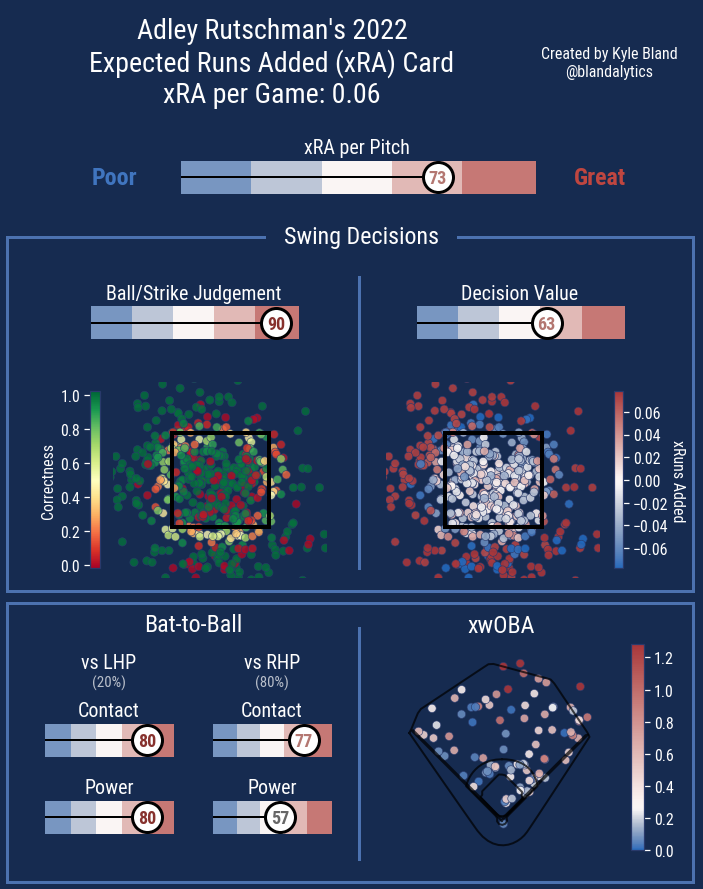

In [207]:
xRA_card(batter_lookup)

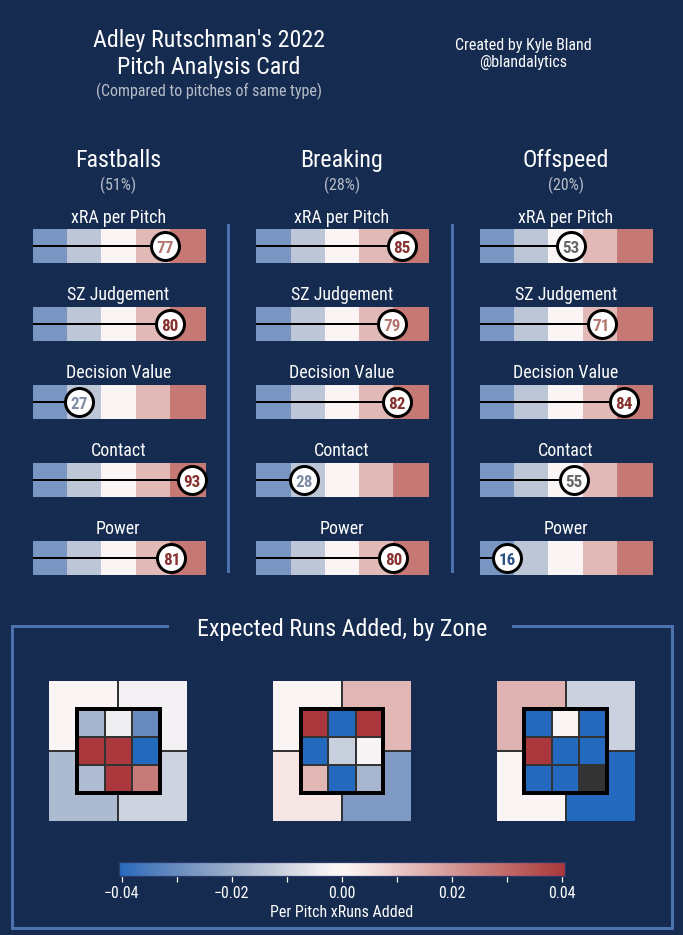

In [208]:
xRA_pitch_card(batter_lookup)

In [ ]:
print('% of All Pitches, by handedness')
batter_data['p_hand'].value_counts().div(batter_data.shape[0]).mul(100)

% of All Pitches, by handedness


R    72.444745
L    27.555255
Name: p_hand, dtype: float64

In [ ]:
# Runs added, for a batter's worst pitch
batter_data.groupby(['batter_name','pitch_type'], as_index=False)['xRuns_added'].sum().groupby('batter_name')['xRuns_added'].min().sort_values(ascending=False).head(10)

batter_name
Yordan Alvarez      0.155668
Juan Soto           0.103936
Evan Phillips       0.084506
Jose Alvarado       0.054318
Freddie Freeman     0.049460
Jose Abreu          0.019458
Victor Caratini    -0.009609
Bryce Harper       -0.030161
Paul Goldschmidt   -0.051824
Rob Brantly        -0.068336
Name: xRuns_added, dtype: float64

# Ideas

## Catcher Framing??

Turning balls into called strikes

(called strike - called strike prediction)

## Stuff Degradation??
How much does it diminish as a game goes on (linked to IP and/or QS?)